<center><h1><b>FORECASTING MODELS</b></h1></center>
Using the R language, we study the temporal and spatial characteristics of earthquake data. We perform a
time series analysis (as a suggestion, we use the TTR package). A time series is a series of data points
ordered and indexed in time. Most commonly, a time series is a sequence taken at successive equally
spaced points in time. It becomes clear that earthquake events do not fit very well with the definition of
a time series, since they are extremely irregular in time. Getting insipiration from the work of [1], we define
two different time series: AEM (Average Earthquakes Magnitude) and MEM (Maximum Earthquakes
Magnitude) using a one year time step. We verify if with the two time series it is possible to predict future
trends of earthquakes in the same region. We perform a fit of the two time series using the ARIMA model
(AutoRegressive Integrated Moving Average). We also try with the SSA model.

[1] H. O. Cekim, et al., Prediction of the earthquake magnitude by time series methods along the East
Anatolian Fault, Turkey, Earth Science Informatics 14 (2021) 1339

In [1]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(forecast)
library(Rssa)
library(TTR)
library(ggplot2)
library(zoo)
options(repr.plot.width = 18, repr.plot.height = 8)


Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union



Caricamento pacchetto: ‘lubridate’


I seguenti oggetti sono mascherati da ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Caricamento del pacchetto richiesto: svd



The speed of the routines will be slower as well.


Caricamento pacchetto: ‘Rssa’


Il seguente oggetto è mascherato da ‘package:stats’:

    decompose



Caricamento pacchetto: ‘zoo’


I seguenti oggetti sono mascherati da ‘package:base’:

    as.Date, as.Date.numeric




---

# LOADING DATA

In [2]:
df1 <- read.table("./data/earthquakes_years_2000_2025.csv", header=TRUE, sep=',')
df2 <- read.table("./data/earthquakes_years_1925_2000.csv", header=TRUE, sep=',')
cat("The 1st database has ", nrow(df1), " rows", "\n")
cat("The 2nd database has ", nrow(df2), " rows", "\n")
df <- rbind(df1, df2)
cat("The final database has ", nrow(df), " rows", "\n")

The 1st database has  13988  rows 
The 2nd database has  14850  rows 
The final database has  28838  rows 


In [3]:
df$time <- as.POSIXct(df$time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [4]:
df_cleaned <- df[, c('time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'id','place','status') ]
head(df_cleaned)
sum(is.na(df_cleaned))

,time,latitude,longitude,depth,mag,magType,id,place,status
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,2025-06-24 03:04:54,41.4136,19.5656,10.000,4.2,mb,us7000q8c1,"7 km N of Shijak, Albania",reviewed
2,2025-06-21 14:56:54,38.0214,20.2244,53.184,4.2,mb,us6000qlmp,"27 km SW of Lixoúri, Greece",reviewed
3,2025-06-21 13:25:52,37.9115,20.1867,10.000,4.5,mb,us6000qlmf,"38 km SW of Lixoúri, Greece",reviewed
4,2025-06-01 16:44:09,43.1747,17.9562,10.000,4.0,mb,us6000qh9w,"8 km ENE of Crnići, Bosnia and Herzegovina",reviewed
5,2025-05-22 22:52:00,42.5041,18.3603,10.000,4.0,mb,us7000q0z4,"12 km WNW of Igalo, Montenegro",reviewed
6,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,us7000q0g6,"2 km NE of Besenello, Italy",reviewed


[1] 0

In [5]:
# pick only years
df_cleaned$year <- year(df_cleaned$time)

# count the AEM and MEM
yearly_data <- df_cleaned %>%
  group_by(year) %>%
  summarise(
    AEM = mean(mag, na.rm = TRUE),
    MEM = max(mag, na.rm = TRUE)
  ) %>%
  arrange(year)

head(yearly_data)

year,AEM,MEM
<dbl>,<dbl>,<dbl>
1925,5.395000,5.75
1926,5.653333,5.93
1927,5.564286,6.02
1928,5.616000,5.98
1929,5.351000,5.53
1930,5.650000,6.64


In [6]:
yearly_data$year

[1] 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939
[16] 1940 1941 1942 1943 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
[31] 1956 1957 1958 1959 1960 1962 1963 1964 1966 1967 1968 1969 1970 1971 1972
[46] 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
[61] 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
[76] 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
[91] 2018 2019 2020 2021 2022 2023 2024 2025

## Calculate Descriptive Statistics for AEM and MEM

In [33]:
library(moments)  # for skewness and kurtosis
library(tseries)  # for ADF test

# AEM statistics
min_AEM <- min(yearly_data$AEM, na.rm = TRUE)
max_AEM <- max(yearly_data$AEM, na.rm = TRUE)
mean_AEM <- mean(yearly_data$AEM, na.rm = TRUE)
median_AEM <- median(yearly_data$AEM, na.rm = TRUE)
sd_AEM <- sd(yearly_data$AEM, na.rm = TRUE)

# MEM statistics
min_MEM <- min(yearly_data$MEM, na.rm = TRUE)
max_MEM <- max(yearly_data$MEM, na.rm = TRUE)
mean_MEM <- mean(yearly_data$MEM, na.rm = TRUE)
median_MEM <- median(yearly_data$MEM, na.rm = TRUE)
sd_MEM <- sd(yearly_data$MEM, na.rm = TRUE)

In [34]:
# Create summary table
stats_table <- data.frame(
  Statistic = c("Min", "Max", "Mean", "Median", "Standard Deviation"),
  AEM = c(min_AEM, max_AEM, mean_AEM, median_AEM, sd_AEM),
  MEM = c(min_MEM, max_MEM, mean_MEM, median_MEM, sd_MEM)
)

stats_table

Statistic,AEM,MEM
<chr>,<dbl>,<dbl>
Min,2.9520975,5.1000000
Max,5.9350000,7.0000000
Mean,4.5297619,5.8543069
Median,4.3752809,5.7700000
Standard Deviation,0.9930517,0.4434699


In [9]:
nrow(yearly_data)
min(yearly_data$year)
max(yearly_data$year)

[1] 98

[1] 1925

[1] 2025

In [10]:
# Full sequence of expected years
full_years <- seq(min(yearly_data$year), max(yearly_data$year), by = 1)

# Identify missing years
missing_years <- setdiff(full_years, yearly_data$year)

# Show missing years
missing_years

[1] 1944 1961 1965

---

# FIXING MISSING YEARS PROBLEM
Tehere are three years without earthquakes: 1944, 1961, 1965. What to do with them?
* insert them with values 0, but this will distort the analysis
* insert them leaving NA values, but this will be a problem for Arima
* insert them with the mean fo the two adiacent values (chosen solution)

In [11]:
# Create a full sequence of years
all_years <- data.frame(year = 1925:2025)

# Merge and add missing rows
yearly_data_full <- all_years %>%
  left_join(yearly_data, by = "year") %>%
  arrange(year)

# Put to value 0 that new rows
yearly_data_full <- yearly_data_full %>%
  mutate(
    AEM = na.approx(AEM, rule = 2),
    MEM = na.approx(MEM, rule = 2)
  )

yearly_data <- yearly_data_full

yearly_data[19:21,]

,year,AEM,MEM
,<dbl>,<dbl>,<dbl>
19,1943,5.5225,5.86
20,1944,5.4875,5.77
21,1945,5.4525,5.68


---

## PLOT OF AEM AND MEM

In [12]:
# creating Time Series 
AEM_ts <- ts(yearly_data$AEM, start = min(yearly_data$year), frequency = 1)
MEM_ts <- ts(yearly_data$MEM, start = min(yearly_data$year), frequency = 1)

# simple moving average each 5 years
AEM_SMA5 <- SMA(AEM_ts, n = 5)
MEM_SMA5 <- SMA(MEM_ts, n = 5)

#cat(AEM_SMA5)
str(AEM_ts)

 Time-Series [1:101] from 1925 to 2025: 5.39 5.65 5.56 5.62 5.35 ...


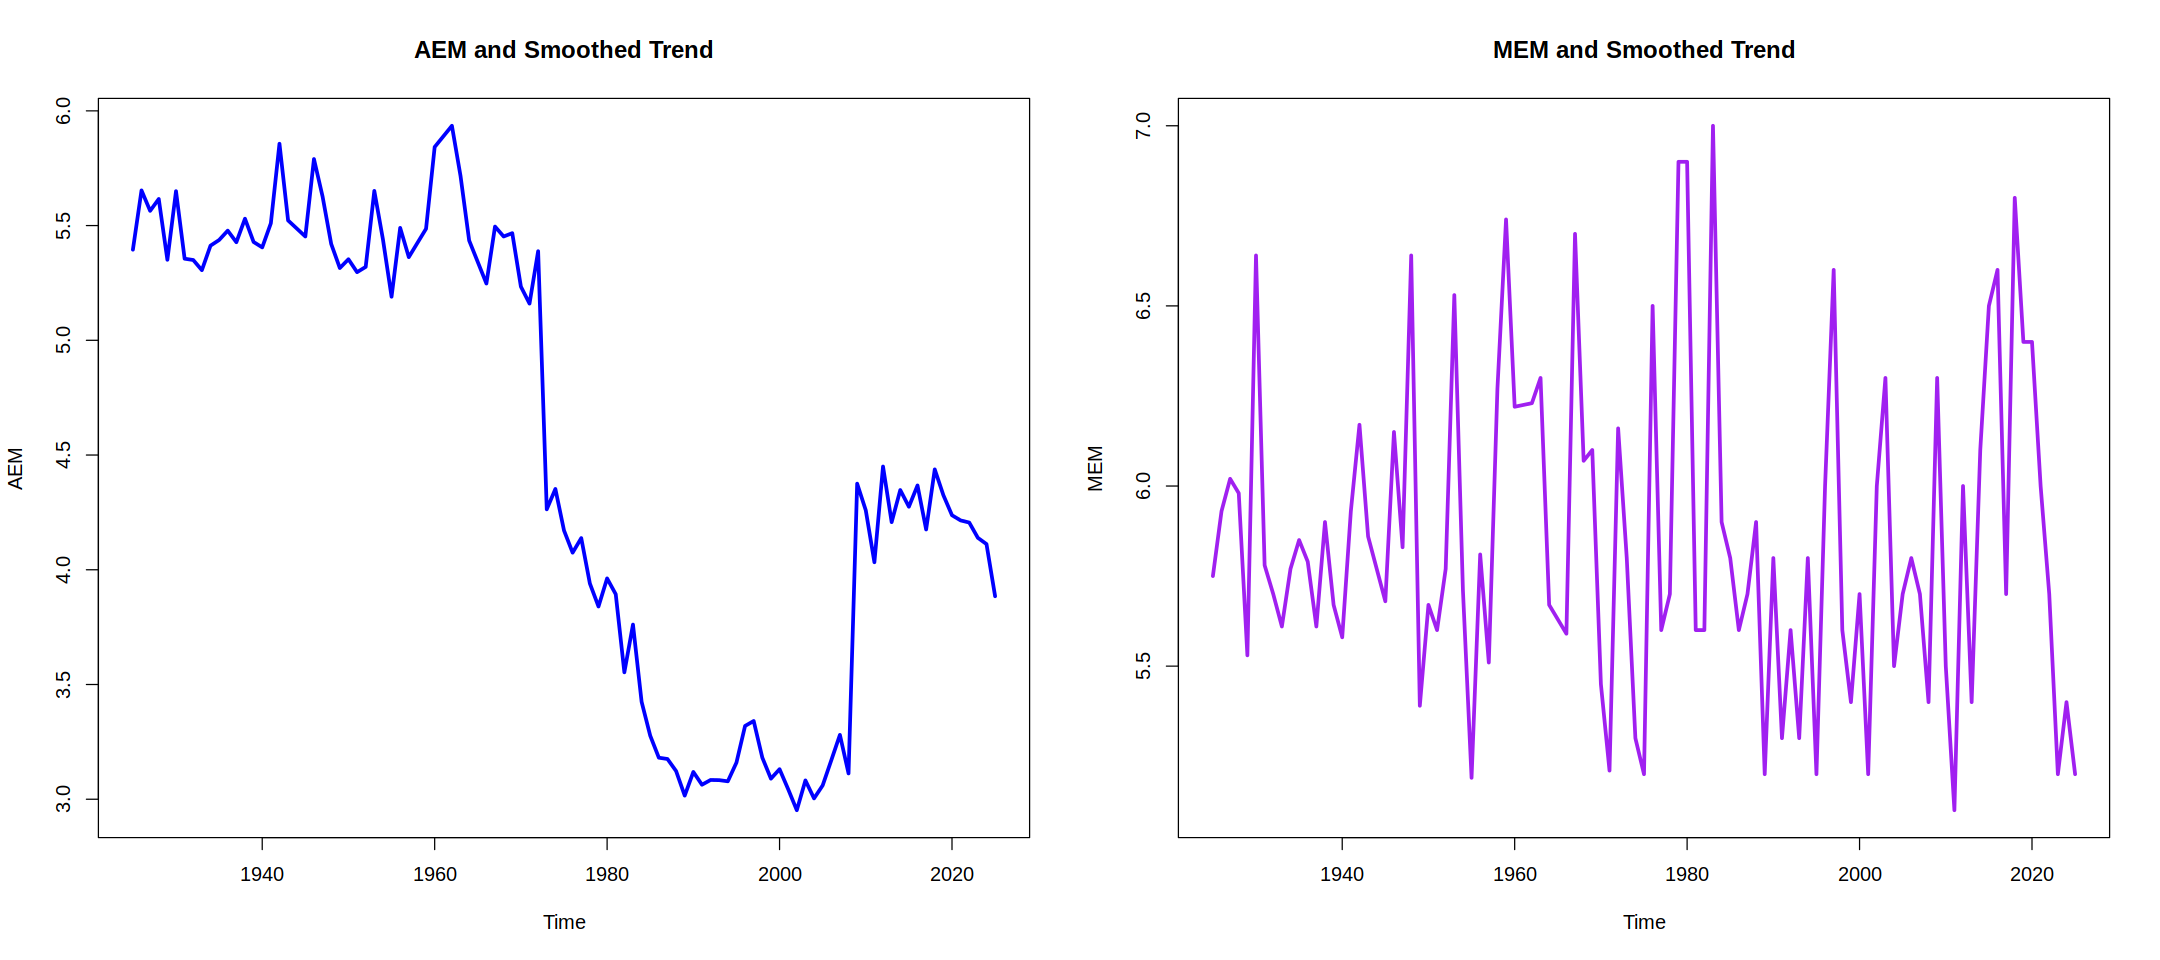

In [13]:
par(mfrow = c(1, 2))  # Two plots side by side
# Plot AEM with SMA
plot(AEM_ts, type = "l", col = "blue", main = "AEM and Smoothed Trend", ylab = "AEM", lwd = 3)
#lines(AEM_SMA5, col = "red",lwd = 3)
#legend("bottomleft", legend = c("AEM", "SMA 5 years"), col = c("blue", "red"), lty = 1, lwd = 3)

# Plot MEM with SMA
plot(MEM_ts, type = "l", col = "purple", main = "MEM and Smoothed Trend", ylab = "MEM", lwd = 3)
#lines(MEM_SMA5, col = "orange", lwd = 3)
#legend("bottomright", legend = c("MEM", "SMA 5 years"), col = c("purple", "orange"), lty = 1, lwd = 3)
par(mfrow = c(1, 1))

---

# ARIMA MODEL

Non-seasonal ARIMA (autoregressive integrated moving average) models are usually denoted as $ARIMA(p, d, q)$, where the parameters $p$, $d$, and $q$ are non-negative integers:

- **$p$** is the order of the autoregressive (AR) part — the number of time lags (uses past values to predict current values).
- **$d$** is the degree of differencing (I part) — the number of times past values are subtracted to make the series stationary.
- **$q$** is the order of the moving average (MA) part — the number of lagged forecast errors in the prediction model.

Seasonal ARIMA models are typically denoted as $ARIMA(p, d, q)(P, D, Q)_m$, where:

- **$P$, $D$, $Q$** are the seasonal counterparts of $p$, $d$, $q$ (seasonal AR, differencing, and MA terms).
- **$m$** is the number of periods in each season (e.g., $m = 12$ for monthly data with yearly seasonality).

When two of the parameters are 0, the model is often referred to by its non-zero component: $ARIMA(1, 0, 0)$ is simply AR(1); $ARIMA(0, 1, 0)$ is I(1) (integrated of order 1); $ARIMA(0, 0, 1)$ is MA(1).

Some well-known special cases of ARIMA include:
- **$ARIMA(0, 0, 0)$** models **white noise**.
- **$ARIMA(0, 1, 0)$** is a **random walk**.
- **$ARIMA(0, 1, 1)$** (without a constant) corresponds to a **basic exponential smoothing model**.


### TESTING THE MODEL
We try to test the model by forecasting the years 2016-2025 and comparing them with real data in that years.

In [14]:
# creating Time Series 
AEM_ts_test <- ts(yearly_data$AEM[1:91], start = min(yearly_data$year), frequency = 1)
MEM_ts_test <- ts(yearly_data$MEM[1:91], start = min(yearly_data$year), frequency = 1)
str(AEM_ts_test)

 Time-Series [1:91] from 1925 to 2015: 5.39 5.65 5.56 5.62 5.35 ...


In [15]:
# Fit ARIMA model for AEM
model_AEM_test <- auto.arima(AEM_ts_test)
# Fit ARIMA model for MEM
model_MEM_test <- auto.arima(MEM_ts_test)

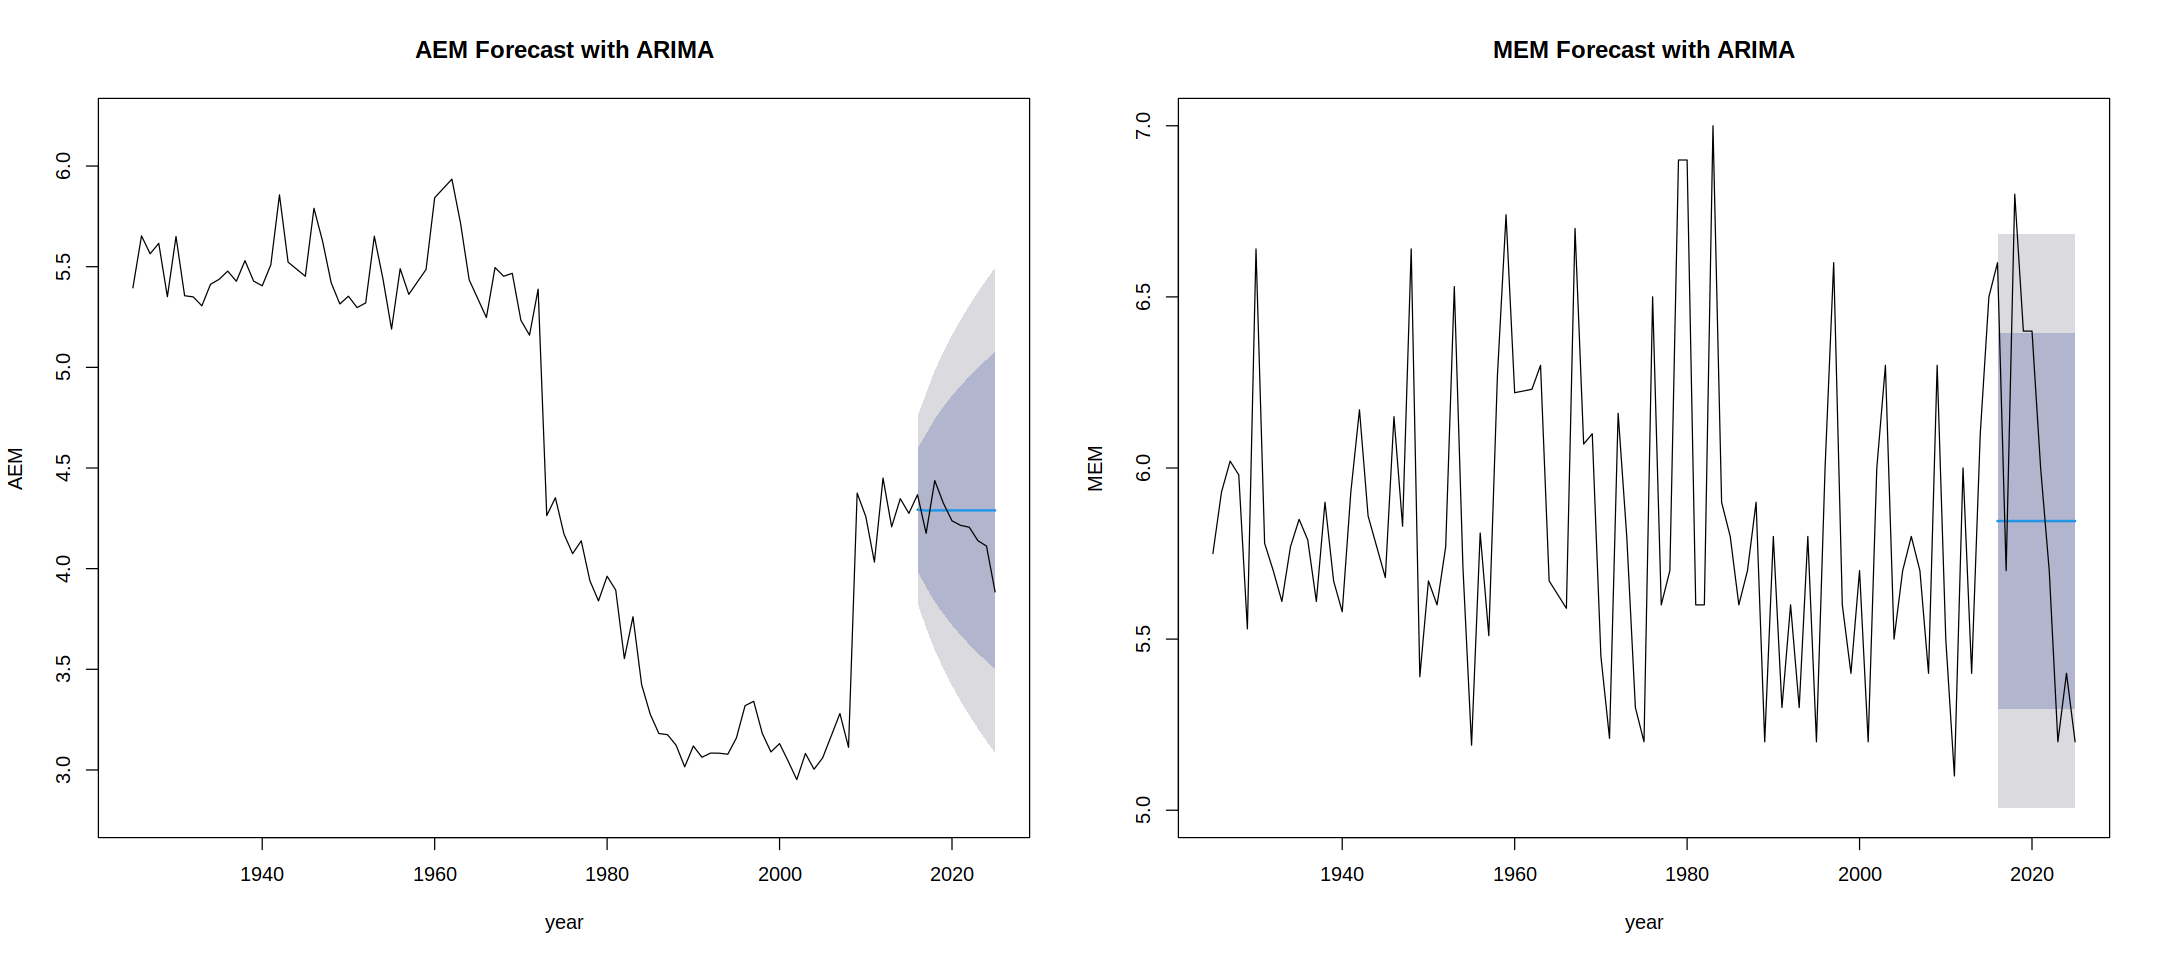

In [16]:
# Forecast next 10 years
forecast_AEM_test <- forecast(model_AEM_test, h = 10)
# Forecast next 10 years
forecast_MEM_test <- forecast(model_MEM_test, h = 10)

# PLOT:
par(mfrow = c(1, 2))  # Two plots side by side
start_year <- 1925
end_year <- 2025
# Plot forecast
plot(forecast_AEM_test, main = "AEM Forecast with ARIMA", include = 0, 
     ylab = "AEM", xlab='year', xlim = c(start_year, end_year), ylim=c(2.8,6.2))
lines(AEM_ts, col = "black", lwd = 1)
# Plot forecast
plot(forecast_MEM_test, main = "MEM Forecast with ARIMA", include = 0, 
     ylab = "MEM", xlab='year', xlim = c(start_year, end_year), ylim=c(5,7))
lines(MEM_ts, col = "black", lwd = 1)
# Reset to default
par(mfrow = c(1, 1))

Here we see the historical data (in black), the forecasted values (blue line), the confidence intervals (gray shaded area), typically at 80% and 95%.

For the AEM time series, even though the real data stays within the confidence interval, the prediction is not very precise.  
In the case of the MEM time series, the actual values go beyond the confidence limits.  
This highlights the limitations of the ARIMA model.

---

## FORECASTING THE FUTURE
Let's try now to use the whole data (1925-2025) to forecast the next 10 (2026-2035).

In [17]:
# Fit ARIMA model for AEM
model_AEM <- auto.arima(AEM_ts)
summary(model_AEM)

Series: AEM_ts 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.2614
s.e.   0.0970

sigma^2 = 0.05253:  log likelihood = 5.89
AIC=-7.78   AICc=-7.65   BIC=-2.57

Training set error measures:
                      ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.01831067 0.2269236 0.1482896 -0.5605795 3.342267 0.9658845
                    ACF1
Training set -0.01171903

ARIMA(1,1,0) is a random walk with a moving average component, a very common model for time series with small trends and some noise.

ARIMA(1,1,0) means: p = 1: one autoregressive (AR) term, i.e. it uses the previous value to help predict the current one; d = 1: first-order differencing was applied to make the time series stationary (i.e., the trend or level was removed); q = 0: no moving average terms.

The model says that the change in average magnitude ($\Delta$AEM) is related to its past value, with some noise. In simpler terms: this is a random walk with an autoregressive correction.

In [18]:
# Fit ARIMA model for MEM
model_MEM <- auto.arima(MEM_ts)
summary(model_MEM)

Series: MEM_ts 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1    mean
      0.1638  5.8532
s.e.  0.1042  0.0504

sigma^2 = 0.1939:  log likelihood = -59.48
AIC=124.95   AICc=125.2   BIC=132.8

Training set error measures:
                       ME      RMSE       MAE        MPE     MAPE     MASE
Training set 0.0001691928 0.4359673 0.3486043 -0.5329756 5.898996 0.778656
                     ACF1
Training set -0.005700917

ARIMA(0,0,1) means: p = 0: no autoregressive terms; d = 0: no differencing, so the data is already stationary (i.e., its statistical properties don’t change over time); q = 1: one moving average (MA) term.

This is a simple MA(1) model with a constant, meaning that each value in the time series is modeled as a weighted average of the previous error and a constant baseline (mean of 5.85).

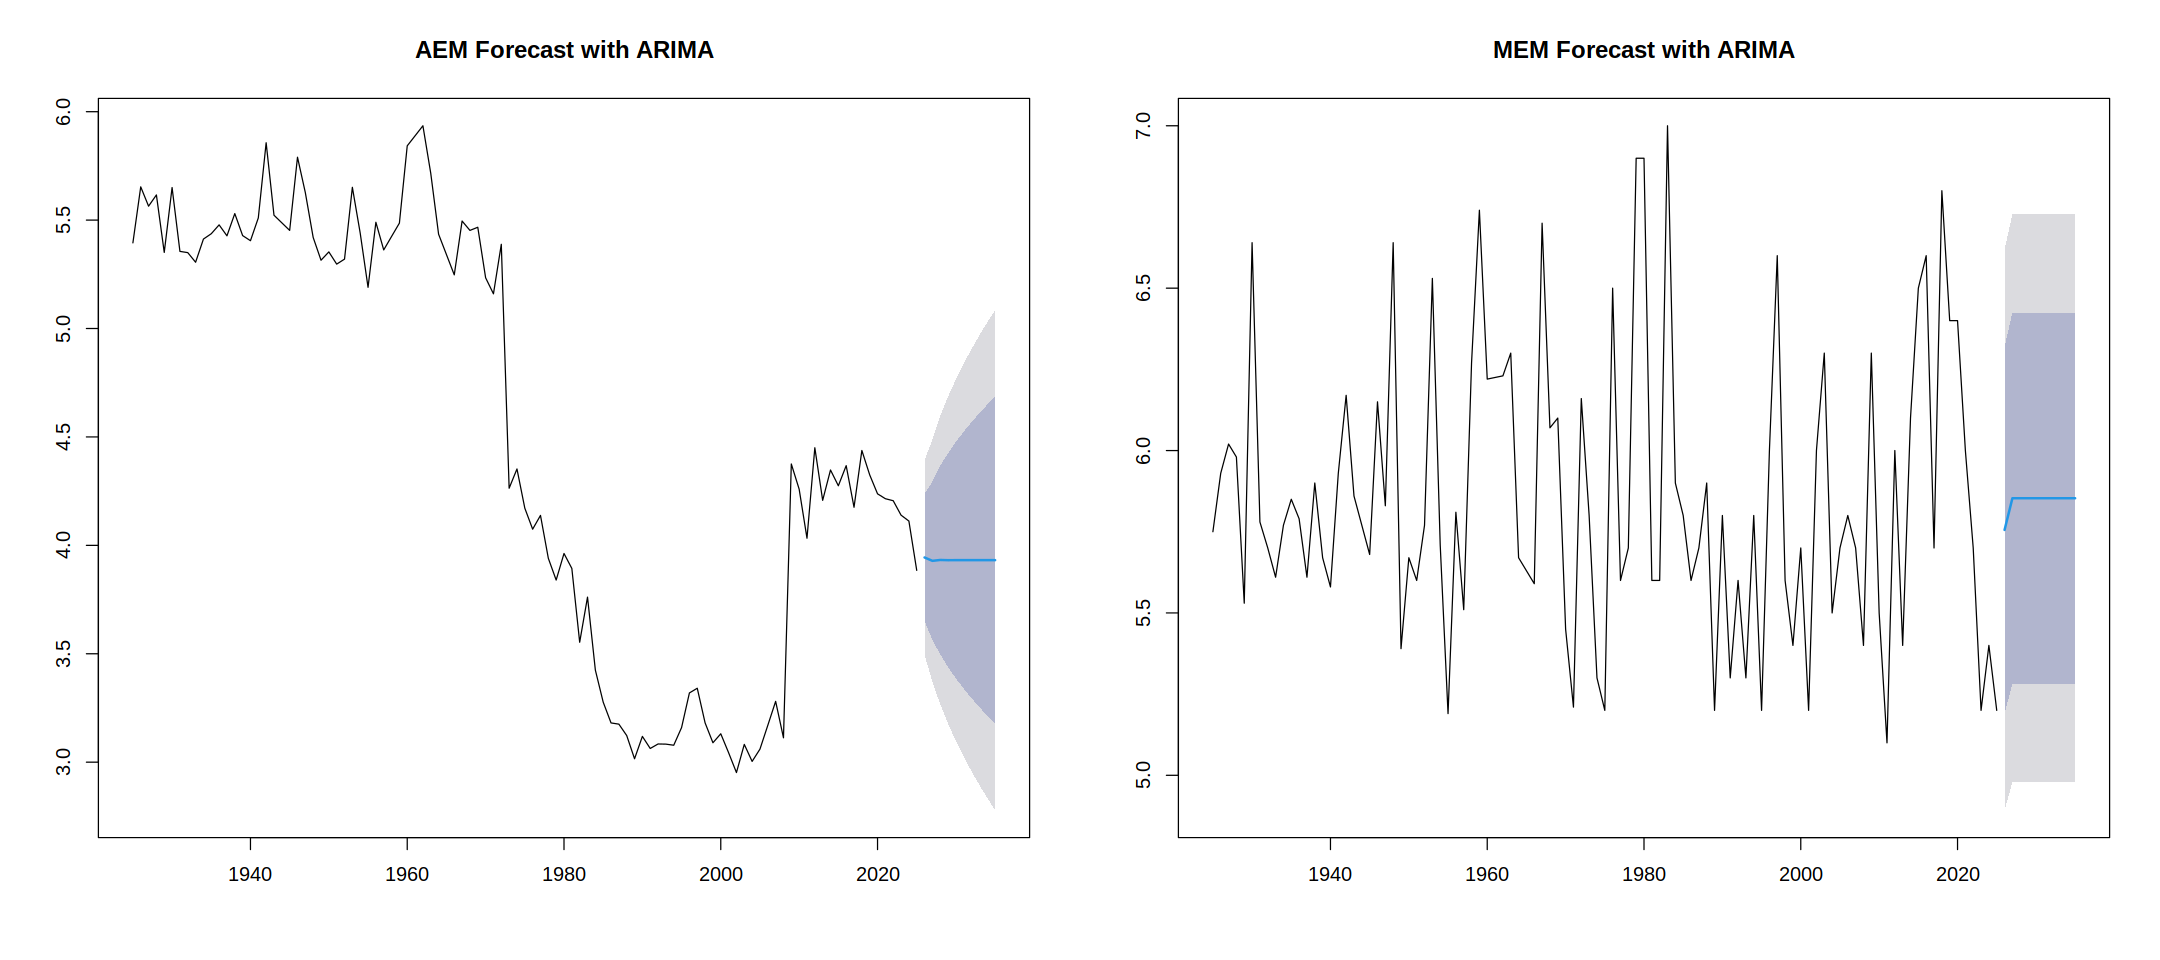

In [19]:
# Forecast next 10 years
forecast_AEM <- forecast(model_AEM, h = 10)
# Forecast next 10 years
forecast_MEM <- forecast(model_MEM, h = 10)


par(mfrow = c(1, 2))  # Two plots side by side
# Plot forecast
plot(forecast_AEM, main = "AEM Forecast with ARIMA")
# legend("topright", 
#        legend = c("Fitted", "Forecast", "80% CI", "95% CI"), 
#        col = c("black", "blue", "gray70", "gray90"), 
#        lty = c(1,1,1,1), 
#        lwd = c(1,2,6,10),
#        bty = "n")

# Plot forecast
plot(forecast_MEM, main = "MEM Forecast with ARIMA")
# Reset to default
par(mfrow = c(1, 1))


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)
Q* = 6.7734, df = 9, p-value = 0.6607

Model df: 1.   Total lags used: 10



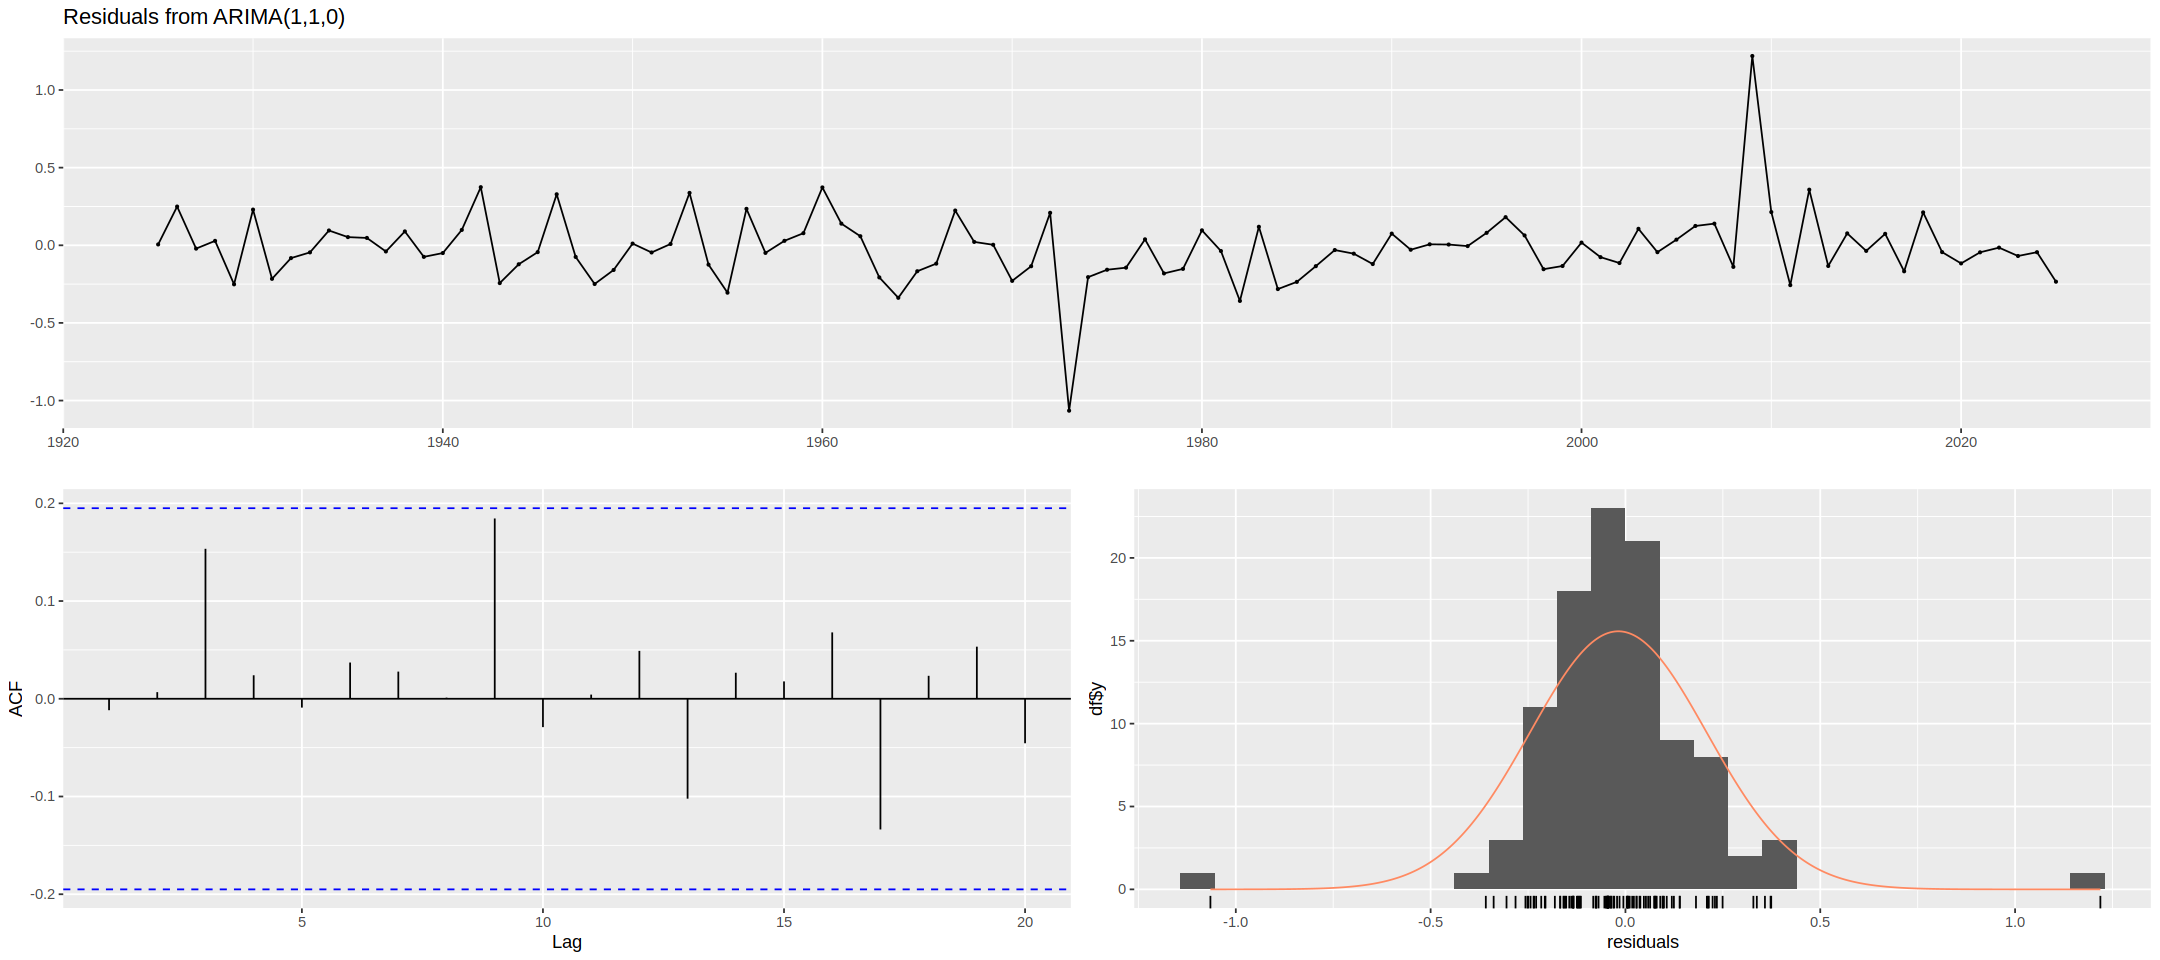


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 9.8215, df = 9, p-value = 0.3651

Model df: 1.   Total lags used: 10



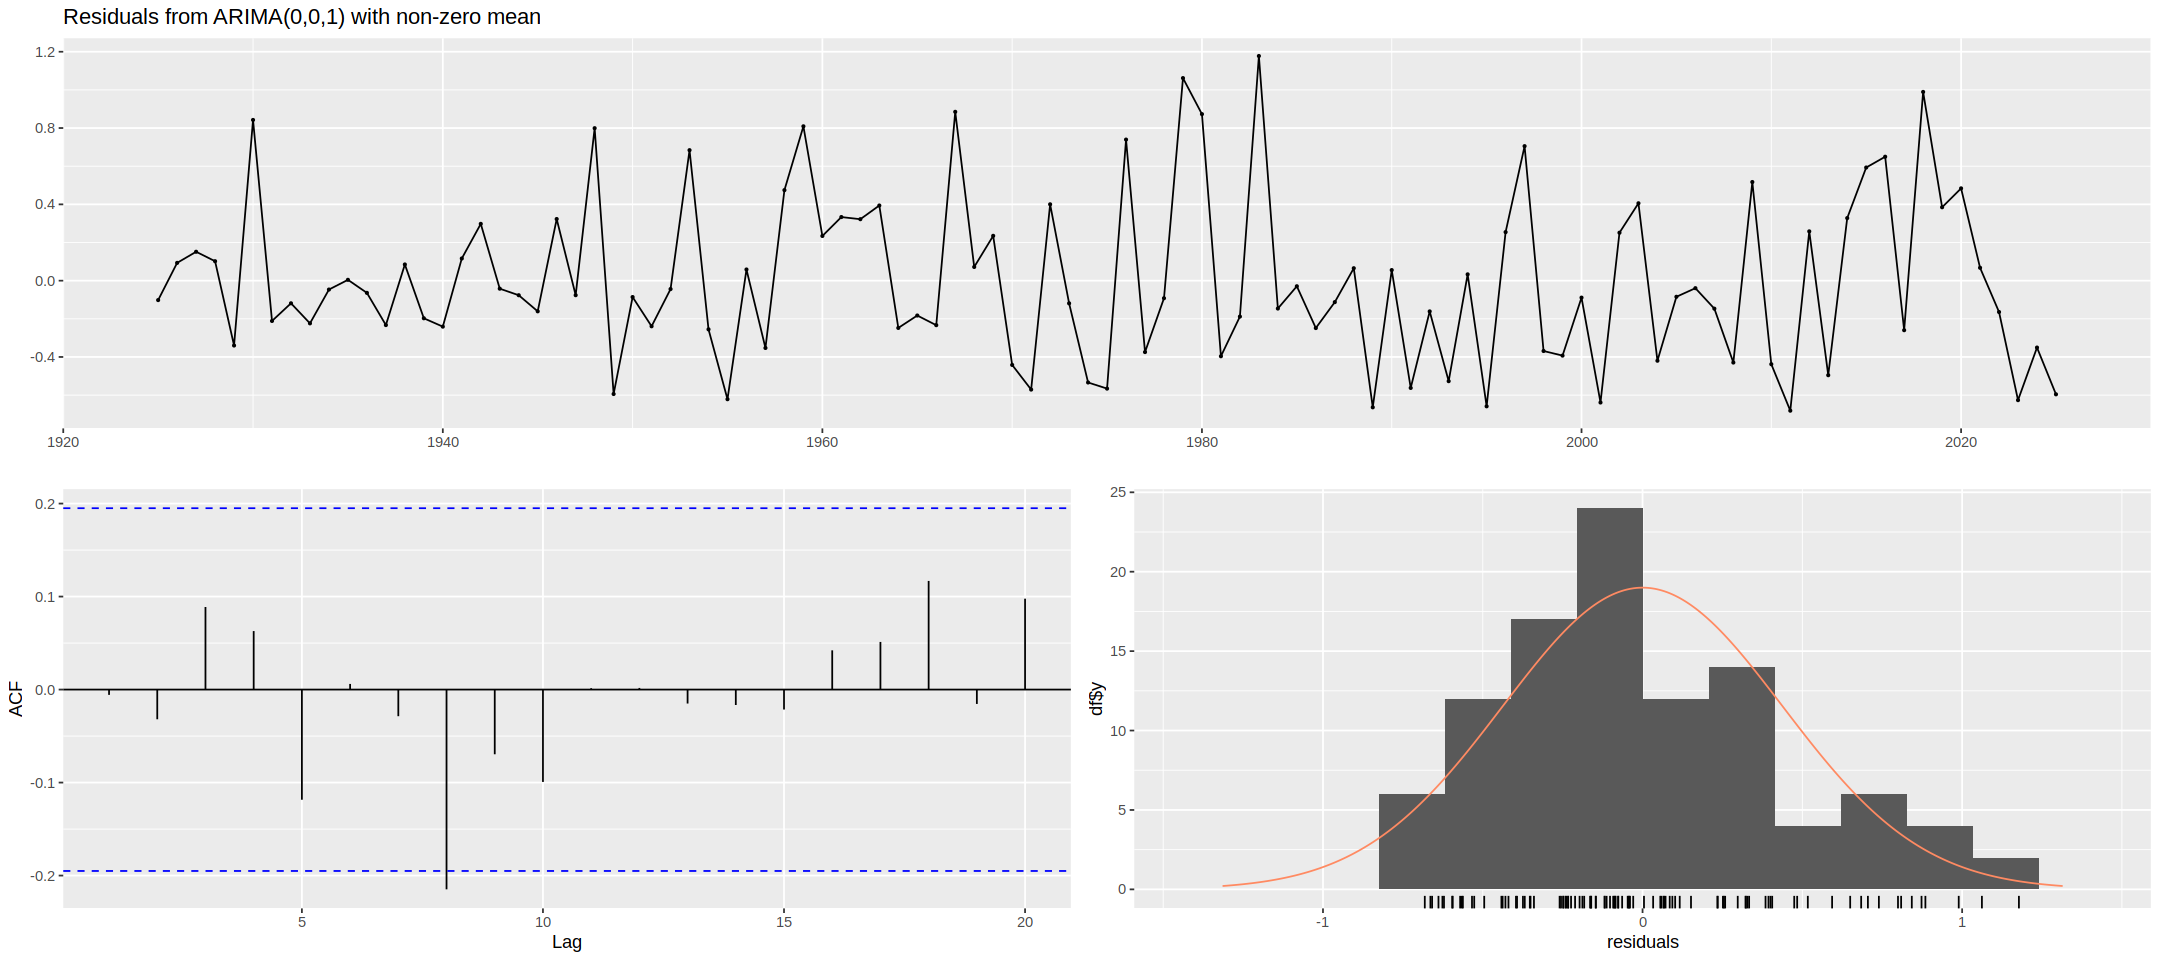

In [20]:
# AEM Residuals check
checkresiduals(model_AEM)

# MEM Residuals check
checkresiduals(model_MEM)

Of the three plots above: 
* the upper one shows the residuals, i.e. the difference between the actual and fitted values; we excpect some random noise, no patterns or trends
* at the bottom left we have the ACF (Autocorrelation Function) of the residuals, to see if they resemble white noise (no pattern); we expect it to lie within the confidence bands (i.e., no significant autocorrelation left)
* at bottom right we performs a Ljung-Box test to check whether the residuals are uncorrelated (i.e., they don't show leftover structure the model failed to capture); we find in both cases (AEM and MEM) a p-value bigger than 0.05, and so we fail to reject the null hypothesis, which means our residuals look like white noise

---

# SSA MODEL

Singular Spectrum Analysis (SSA) is a powerful and flexible technique for analyzing time series data, particularly when the data are nonlinear, nonstationary, or contain trends and seasonality. Unlike ARIMA models, SSA is a non-parametric approach — it does not require specifying a particular model or assuming stationarity.

The main goal of SSA is to decompose a time series into a sum of interpretable components such as trend, seasonality, and noise. This makes it useful not only for analysis, but also for denoising and forecasting.

SSA consists of four main steps:

1. Embedding: The time series is transformed into a trajectory matrix by creating overlapping subseries (using a sliding window of length `L`), which means every row of the matrix is a slice of L values shifted wrt the values of the previous row
2. Singular Value Decomposition (SVD): The trajectory matrix is decomposed into orthogonal components using SVD. Each component captures a different mode of variation in the data.
3. Grouping: The decomposed components are grouped together based on their patterns — for example, some represent the trend, others capture periodic (seasonal) patterns, and the rest are noise.
4. Reconstruction: The time series is reconstructed using selected components. This allows us to isolate and remove noise, extract the trend or seasonal component, or prepare the data for forecasting.

SSA has several advantages over traditional methods:

- It does not require stationarity or linearity.
- It can be applied to short time series.
- It is effective at denoising and detecting hidden patterns.
- It allows for missing data in some implementations.
- It can be used for forecasting by extending the reconstructed series using methods like vector or recurrent forecasting.

#### SSA vs ARIMA

| Feature          | ARIMA                        | SSA                           |
|------------------|------------------------------|--------------------------------|
| Model type       | Parametric                   | Non-parametric                 |
| Requires stationarity | Yes                    | No                             |
| Handles nonlinear patterns | Poorly             | Well                           |
| Denoising ability | Limited                    | Strong                         |
| Works on short series | Not ideal             | Yes                            |

In summary, SSA is a versatile technique well suited to uncovering structure in complex time series data, especially when traditional assumptions like stationarity do not hold. It is particularly useful when you want to separate a signal into trend, periodicity, and noise, or when you want to forecast without relying on strict model assumptions.


### TESTING THE MODEL
We try to test the model by forecasting the years 2016-2025 and comparing them with real data in that years.

In [21]:
# creating Time Series 
AEM_ts_test <- ts(yearly_data$AEM[1:91], start = min(yearly_data$year), frequency = 1)
MEM_ts_test <- ts(yearly_data$MEM[1:91], start = min(yearly_data$year), frequency = 1)
str(AEM_ts_test)

 Time-Series [1:91] from 1925 to 2015: 5.39 5.65 5.56 5.62 5.35 ...


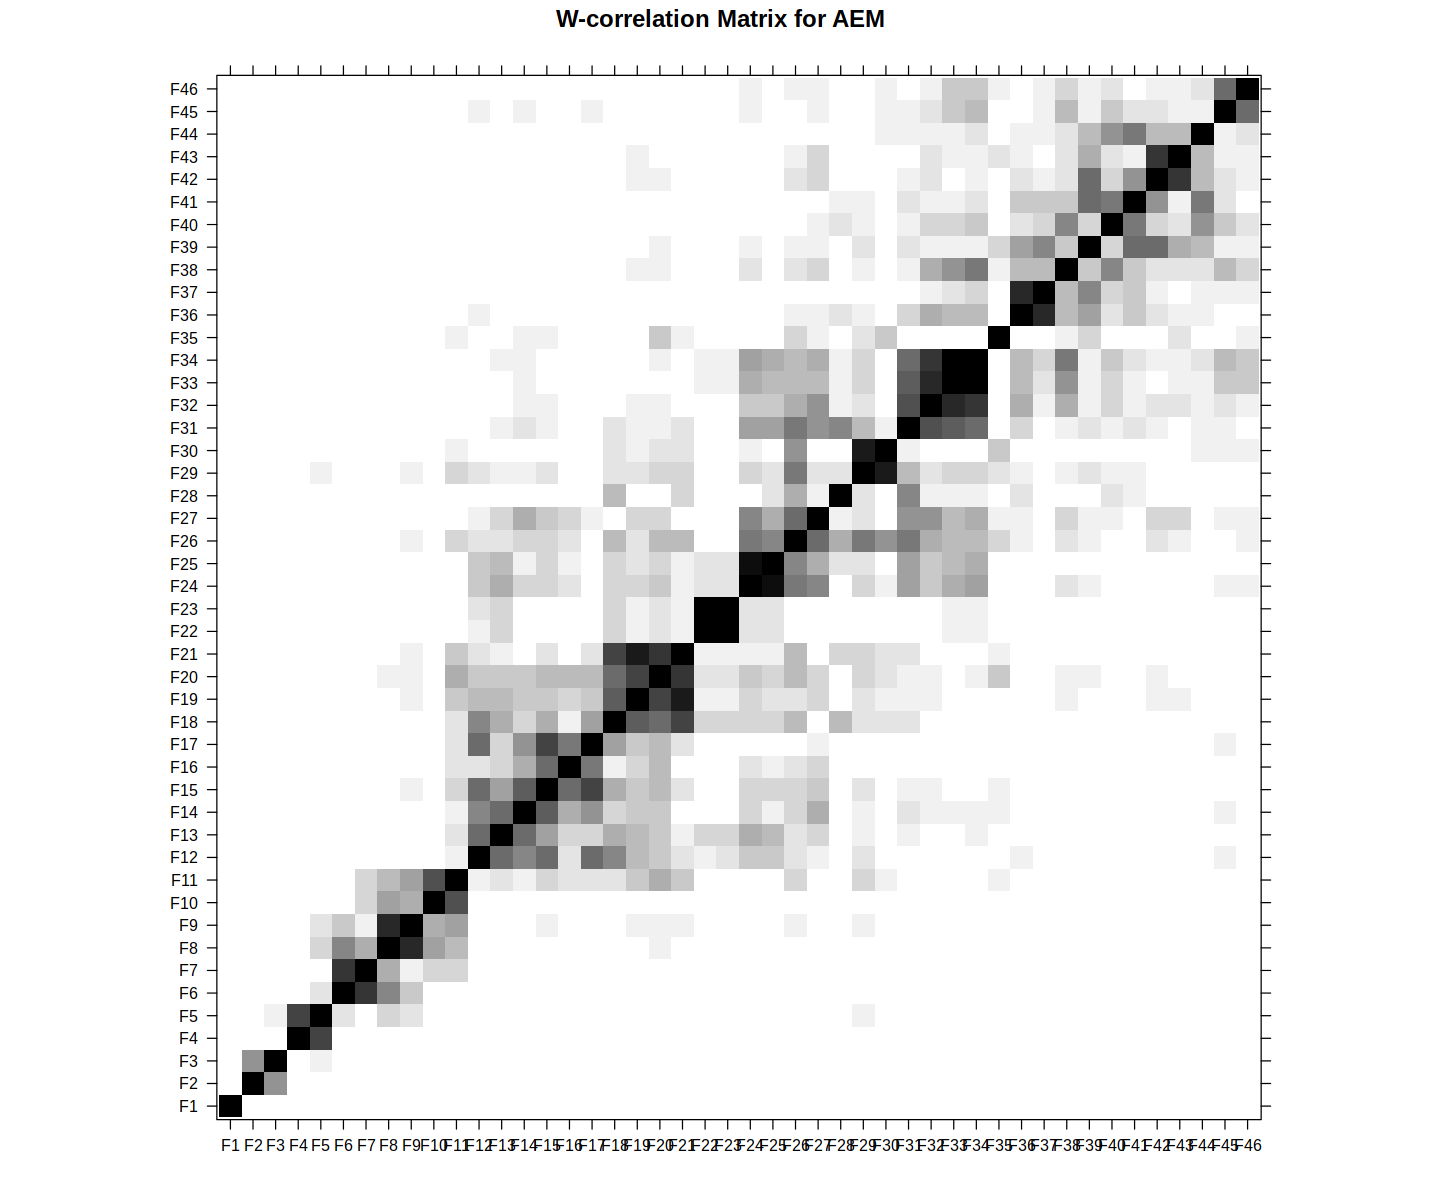

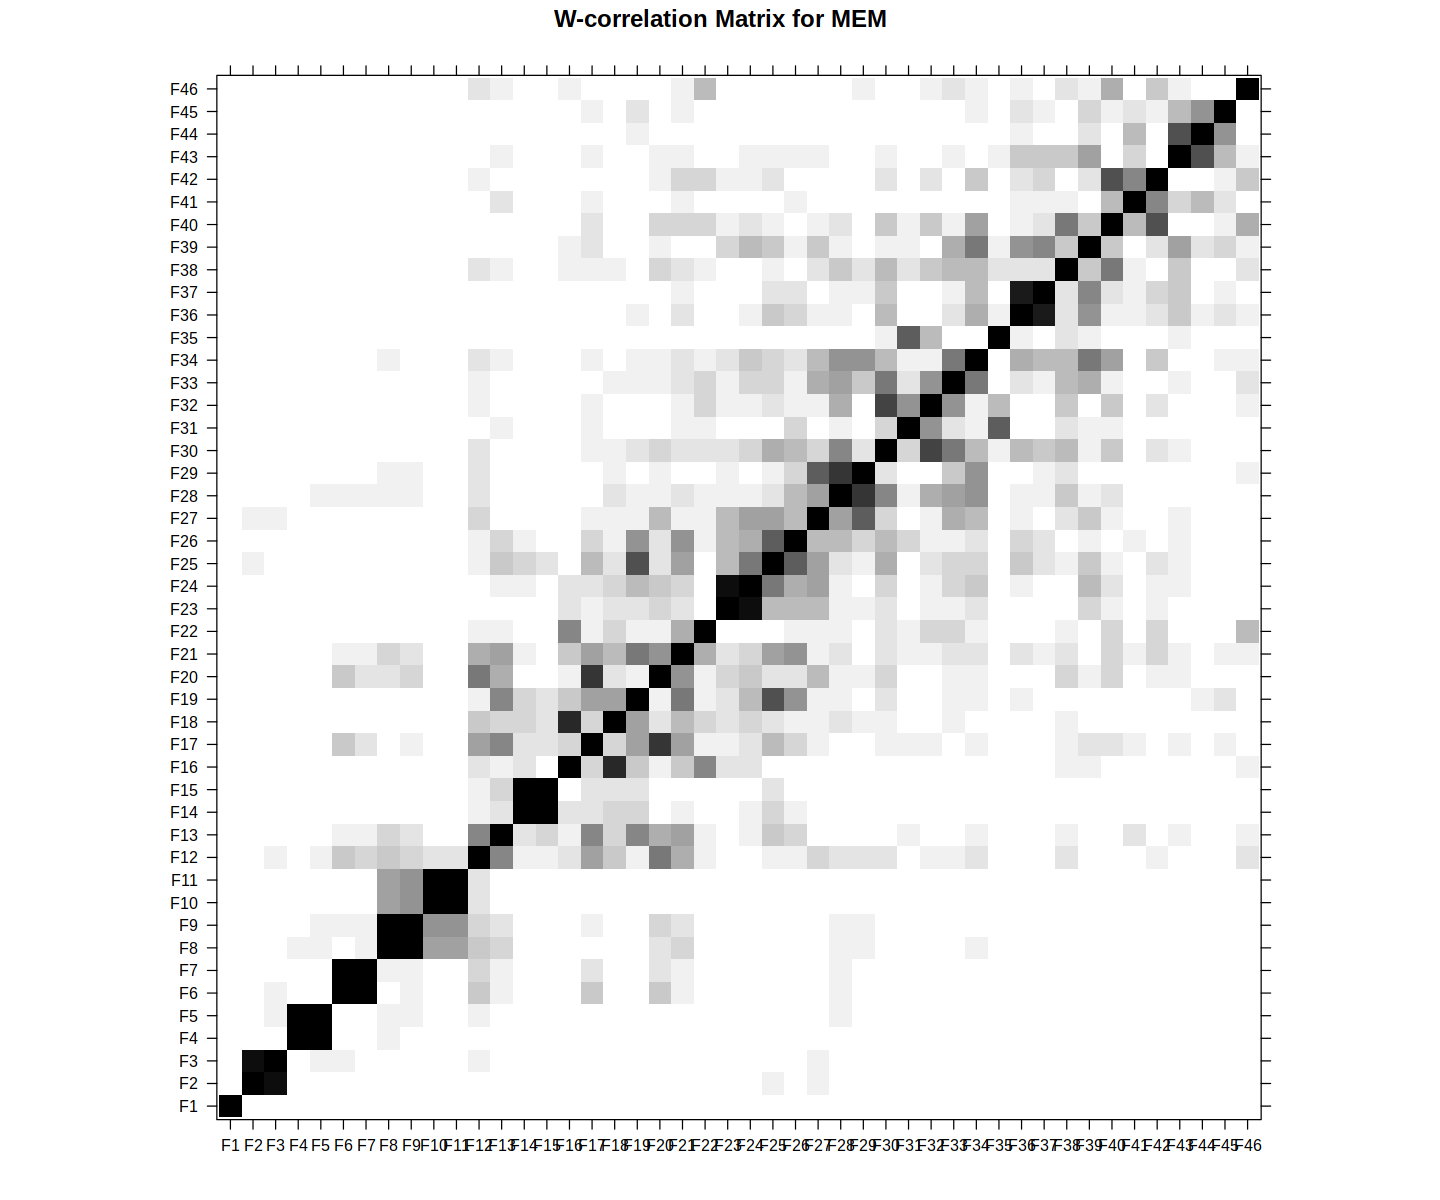

In [22]:
# Apply SSA to the AEM time series
ssa_AEM_test <- ssa(AEM_ts_test)
# Apply SSA to the MEM time series
ssa_MEM_test <- ssa(MEM_ts_test)

options(repr.plot.width = 12, repr.plot.height = 10)
# W-correlation Matrix for AEM
plot(wcor(ssa_AEM_test), main = "W-correlation Matrix for AEM")
# W-correlation Matrix for MEM
plot(wcor(ssa_MEM_test), main = "W-correlation Matrix for MEM")


### RECOSTRUCTION
We groups SSA components observing the correlations between components in the matrix above:
* Trend: the first components (likely the low-frequency structure). This captures the long-term direction (e.g., increasing, decreasing, flat), it should not oscillate rapidly, it should align with the intuition about the overall movement of the data. So we expect to observe a clean, smooth shape that follows the overall growth or decline of the series.  
* Seasonality: This captures regular oscillations with consistent frequency. Amplitude might change slightly, but period should be stable. So we expect to observe waves or cycles that repeat regularly (e.g., sinusoidal pattern).
* Residuals: the last components. This captures high-frequency, erratic, low-amplitude "wiggles" without obvious structure or regularity, it appears more like white noise. So we expect to observe fluctuations with no recognizable pattern — essentially, the leftover noise.

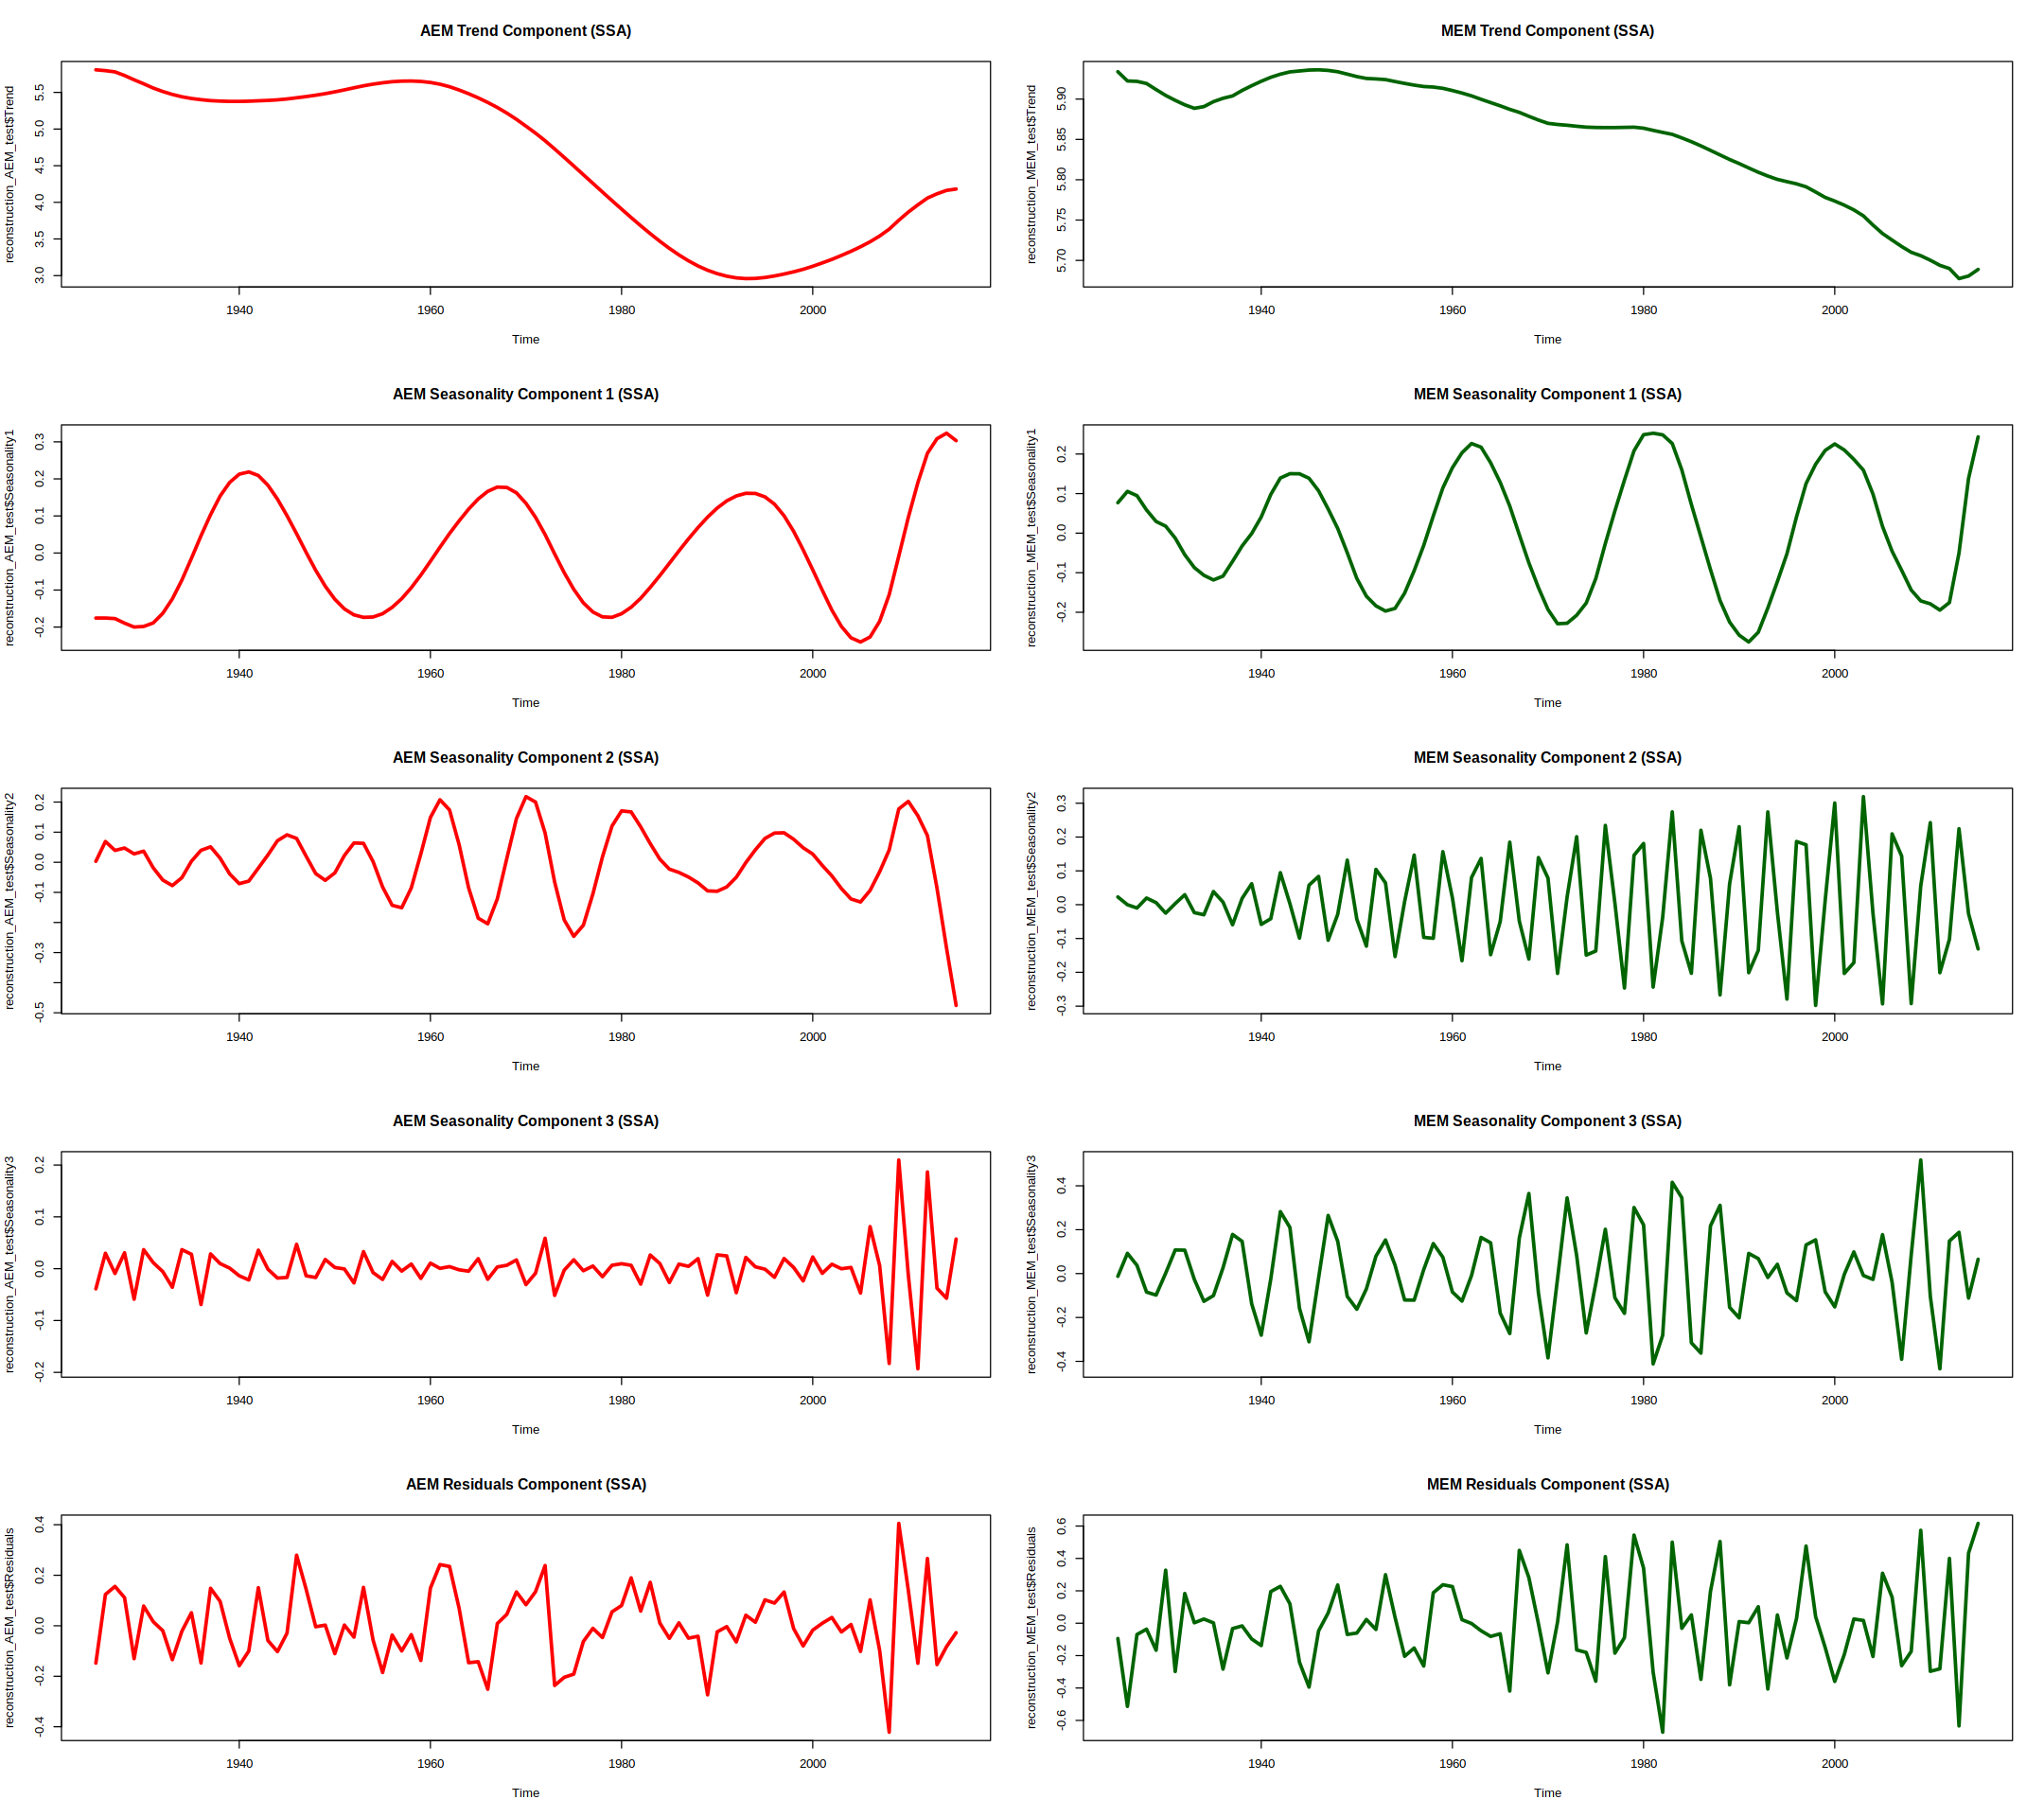

In [23]:
# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_AEM_test <- reconstruct(ssa_AEM_test, 
            groups = list(Trend = 1:3, Seasonality1 = 4:5, Seasonality2 = 6:11, Seasonality3 = 12:13, Residuals = 20:length(ssa_AEM_test)))
# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_MEM_test <- reconstruct(ssa_MEM_test, 
            groups = list(Trend = 1, Seasonality1 = 2:3, Seasonality2 = 4:5, Seasonality3 = 6:11, Residuals = 20:length(ssa_MEM_test)))

# Side by side plots
options(repr.plot.width = 18, repr.plot.height = 16)
par(mfrow = c(5, 2))
plot(reconstruction_AEM_test$Trend, type = "l", col = "red", main = "AEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_MEM_test$Trend, type = "l", col = "darkgreen", main = "MEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_AEM_test$Seasonality1, type = "l", col = "red", main = "AEM Seasonality Component 1 (SSA)", lwd = 3)
plot(reconstruction_MEM_test$Seasonality1, type = "l", col = "darkgreen", main = "MEM Seasonality Component 1 (SSA)", lwd = 3)
plot(reconstruction_AEM_test$Seasonality2, type = "l", col = "red", main = "AEM Seasonality Component 2 (SSA)", lwd = 3)
plot(reconstruction_MEM_test$Seasonality2, type = "l", col = "darkgreen", main = "MEM Seasonality Component 2 (SSA)", lwd = 3)
plot(reconstruction_AEM_test$Seasonality3, type = "l", col = "red", main = "AEM Seasonality Component 3 (SSA)", lwd = 3)
plot(reconstruction_MEM_test$Seasonality3, type = "l", col = "darkgreen", main = "MEM Seasonality Component 3 (SSA)", lwd = 3)
plot(reconstruction_AEM_test$Residuals, type = "l", col = "red", main = "AEM Residuals Component (SSA)", lwd = 3)
plot(reconstruction_MEM_test$Residuals, type = "l", col = "darkgreen", main = "MEM Residuals Component (SSA)", lwd = 3)
par(mfrow = c(1,1))

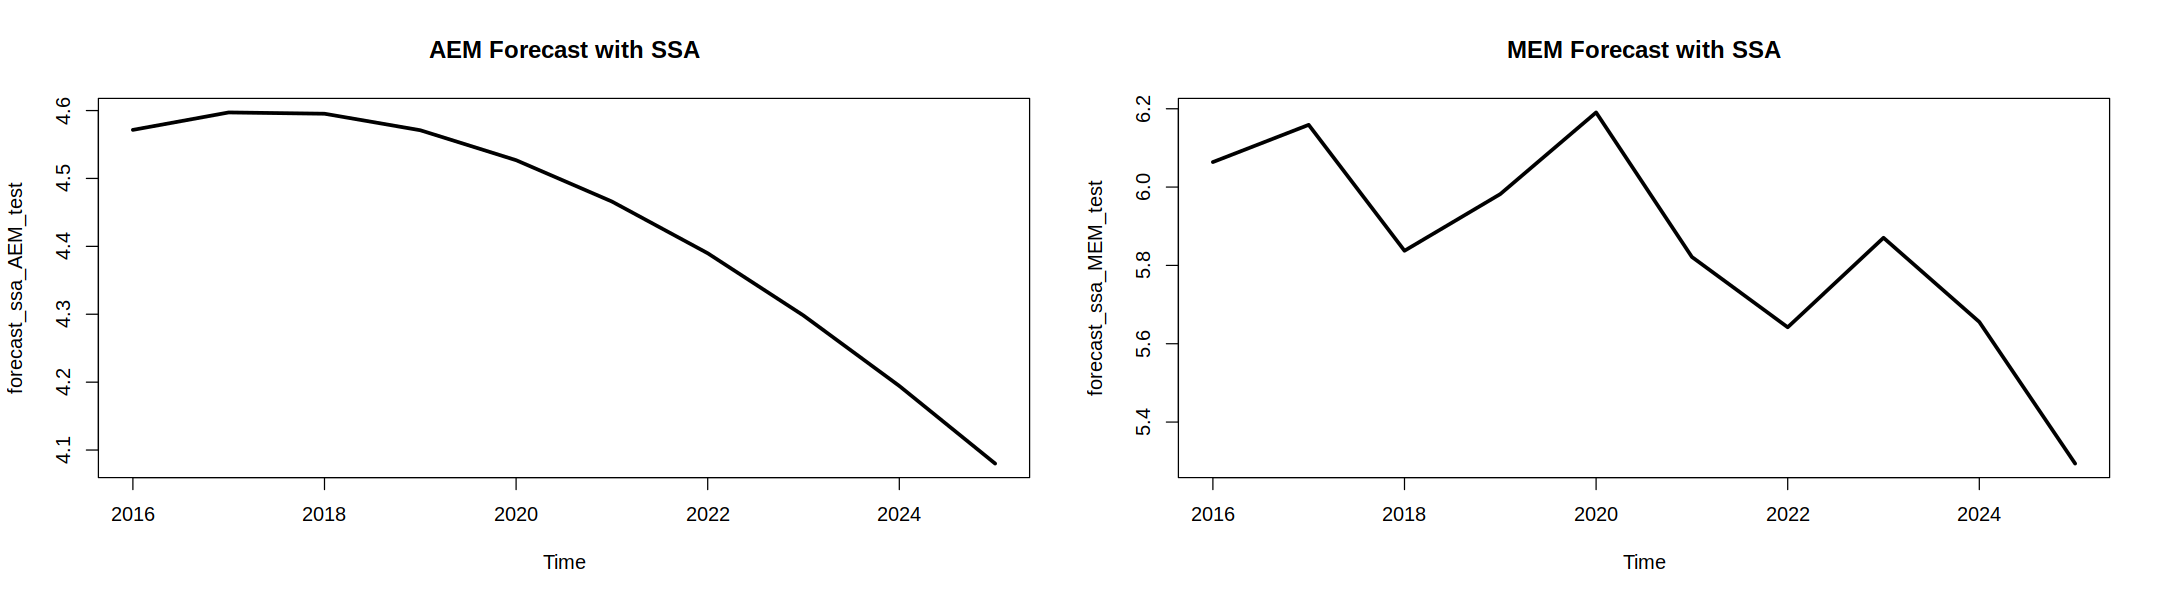

In [24]:
# Forecast next 10 years using SSA
forecast_ssa_AEM_test <- rforecast(ssa_AEM_test, groups = list(1:5), len = 10)
# Forecast for MEM
forecast_ssa_MEM_test <- rforecast(ssa_MEM_test, groups = list(1:5), len = 10)

# Plot the forecast
options(repr.plot.width = 18, repr.plot.height = 5)
par(mfrow = c(1, 2))
plot(forecast_ssa_AEM_test, main = "AEM Forecast with SSA", lwd = 3)
plot(forecast_ssa_MEM_test, main = "MEM Forecast with SSA" , lwd = 3)
par(mfrow = c(1,1))

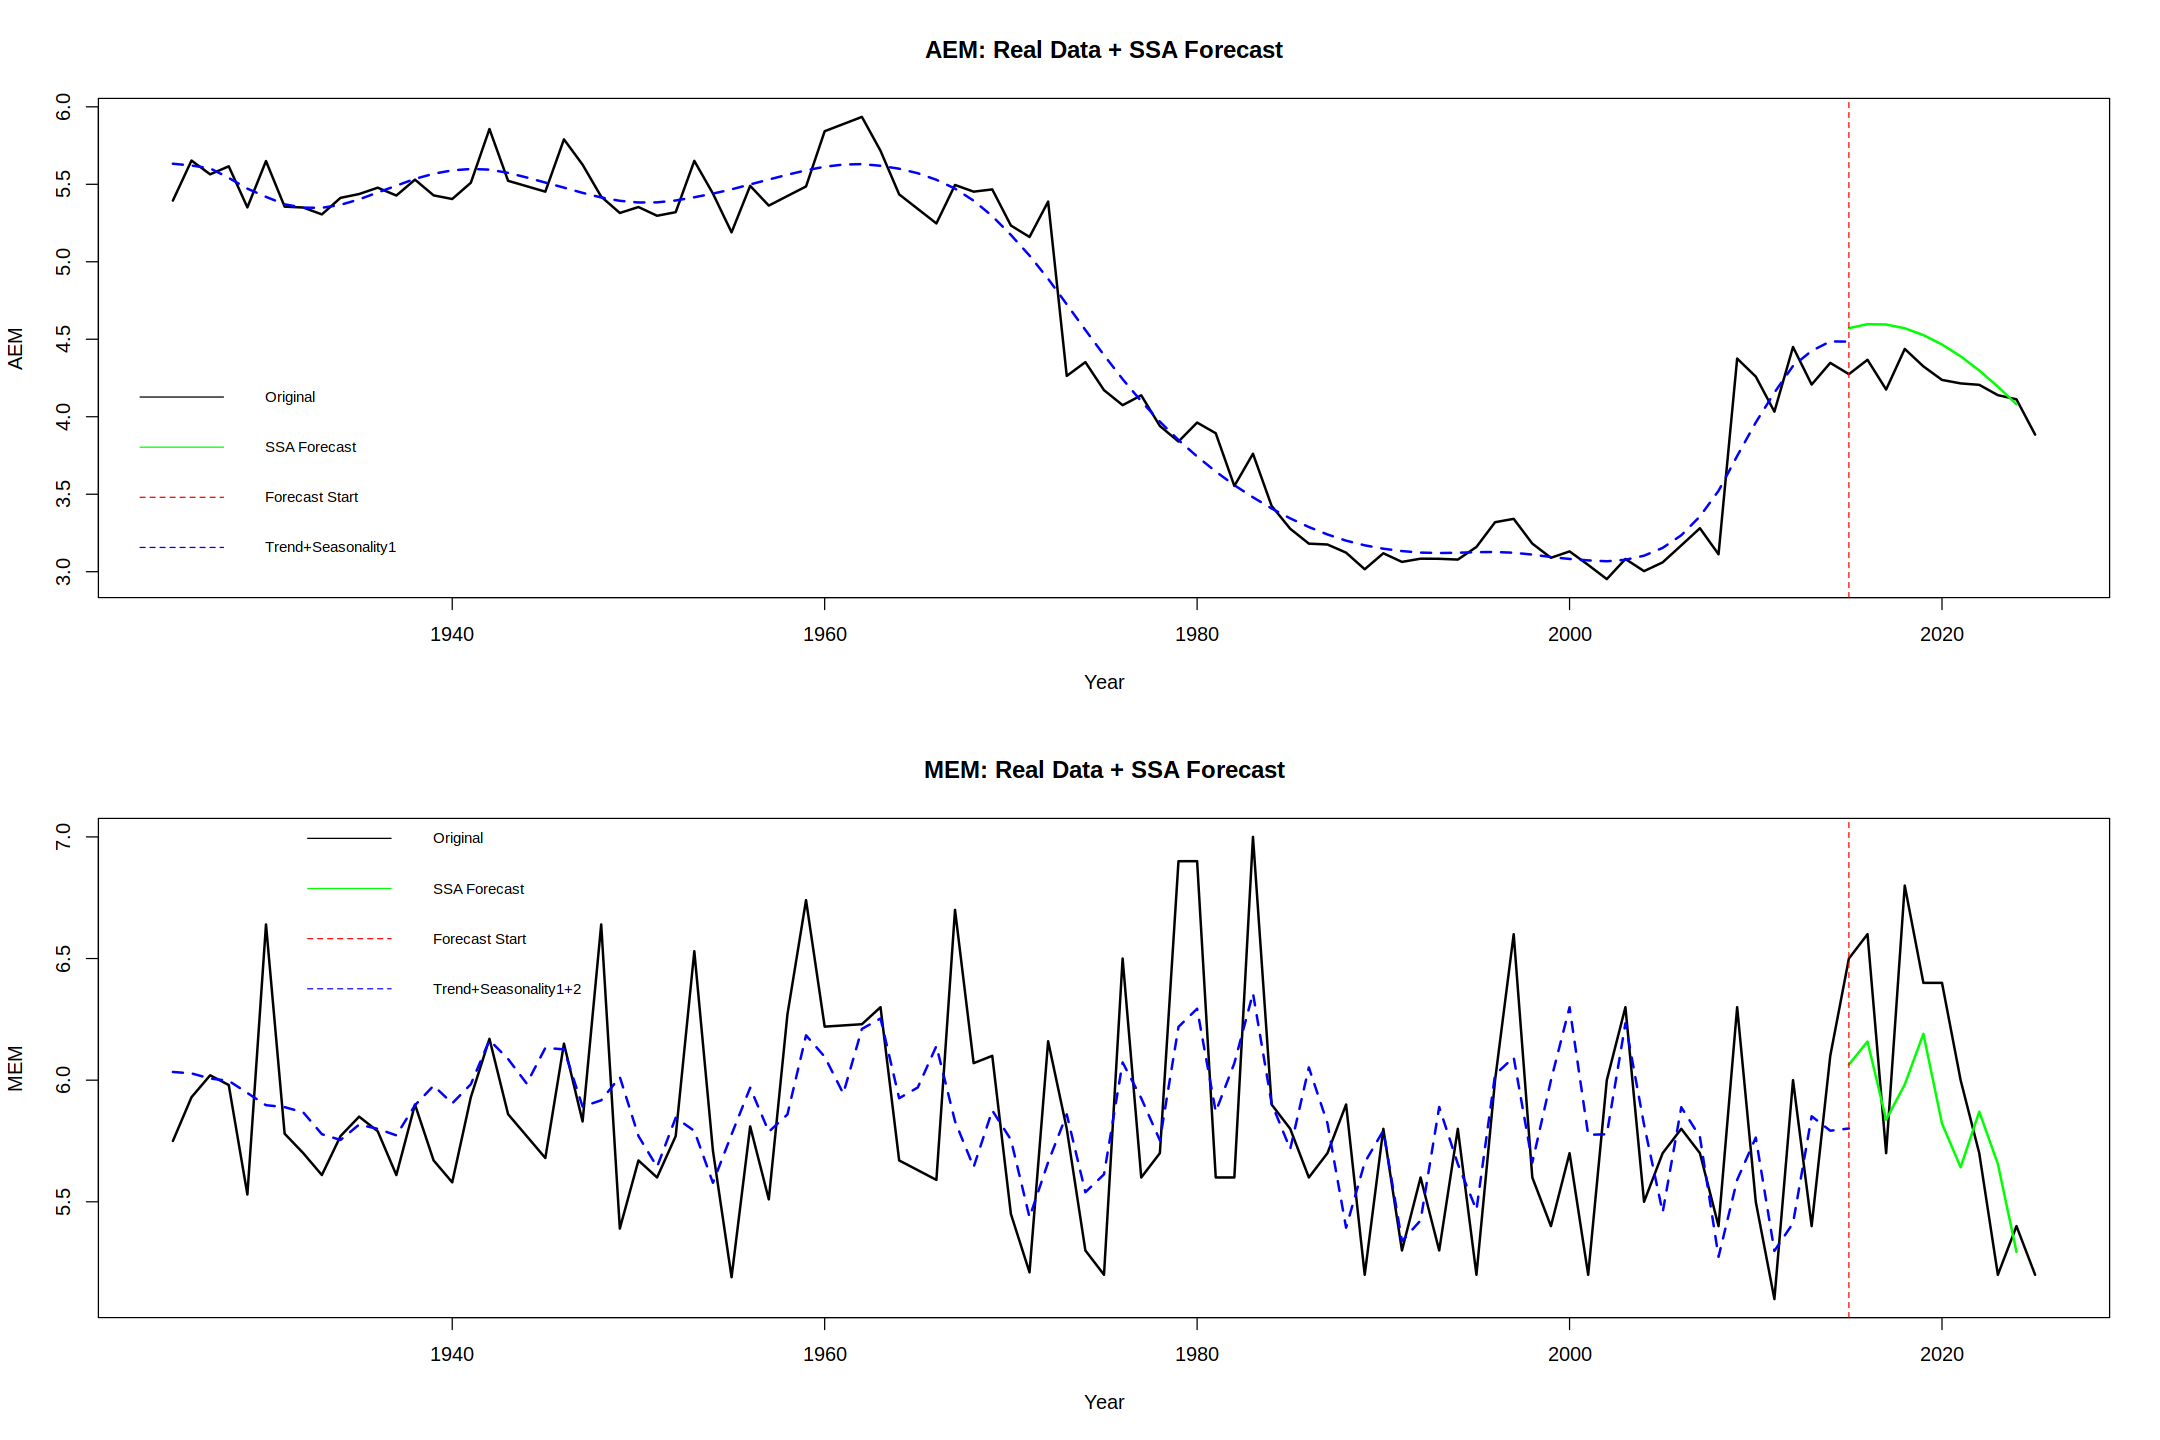

In [25]:
# Forecast series only
forecast_years_test <- (end(AEM_ts_test)[1]):(end(AEM_ts_test)[1] + 10)
# Convert SSA forecast (vector) into time series object
forecast_ts_AEM_test <- ts(forecast_ssa_AEM_test, start = end(AEM_ts_test)[1], frequency = 1)
forecast_ts_MEM_test <- ts(forecast_ssa_MEM_test, start = end(MEM_ts_test)[1], frequency = 1)


# PLOT:
options(repr.plot.width = 18, repr.plot.height = 12)
par(mfrow = c(2, 1))

# PLOT1:
plot(AEM_ts, type = "l", lwd = 2, col = "black", ylim = range(c(AEM_ts_test, forecast_ts_AEM_test)),
     main = "AEM: Real Data + SSA Forecast", xlab = "Year", ylab = "AEM")
lines(reconstruction_AEM_test$Trend + reconstruction_AEM_test$Seasonality1, col = "blue", lwd = 2, lty = 2)  # SSA Trend
lines(forecast_ts_AEM_test, col = "green", lwd = 2)
abline(v = end(AEM_ts_test)[1], col = "red", lty = 2)
legend("bottomleft", legend = c("Original", "SSA Forecast", "Forecast Start", "Trend+Seasonality1"),
       col = c("black", "green", "red","blue"), lty = c(1,1,2,2), bty = "n", cex = 0.75)

# PLOT2:
plot(MEM_ts, type = "l", lwd = 2, col = "black", ylim = range(c(MEM_ts_test, forecast_ts_MEM_test)),
     main = "MEM: Real Data + SSA Forecast", xlab = "Year", ylab = "MEM")
lines(reconstruction_MEM_test$Trend + reconstruction_MEM_test$Seasonality1 + reconstruction_MEM_test$Seasonality2, col = "blue", lwd = 2, lty = 2)  # SSA Trend
lines(forecast_ts_MEM_test, col = "green", lwd = 2)
abline(v = end(MEM_ts_test)[1], col = "red", lty = 2)
legend(x = 1930, y = 7.2, legend = c("Original", "SSA Forecast", "Forecast Start", "Trend+Seasonality1+2"),
       col = c("black", "green", "red","blue"), lty = c(1,1,2,2), bty = "n",cex = 0.75)

par(mfrow = c(1, 1))


For the AEM time series, we reconstructed the data using the trend component and the first seasonal component, as these showed the least noise in the component plots.  
Similarly, for the MEM series, we used the trend and the first two seasonal components.  
As shown, the reconstruction aligns well with the original data, indicating a good result.

## FORECASTING THE FUTURE
Let's try now to use the whole data (1925-2025) to forecast the next 10 (2026-2035).

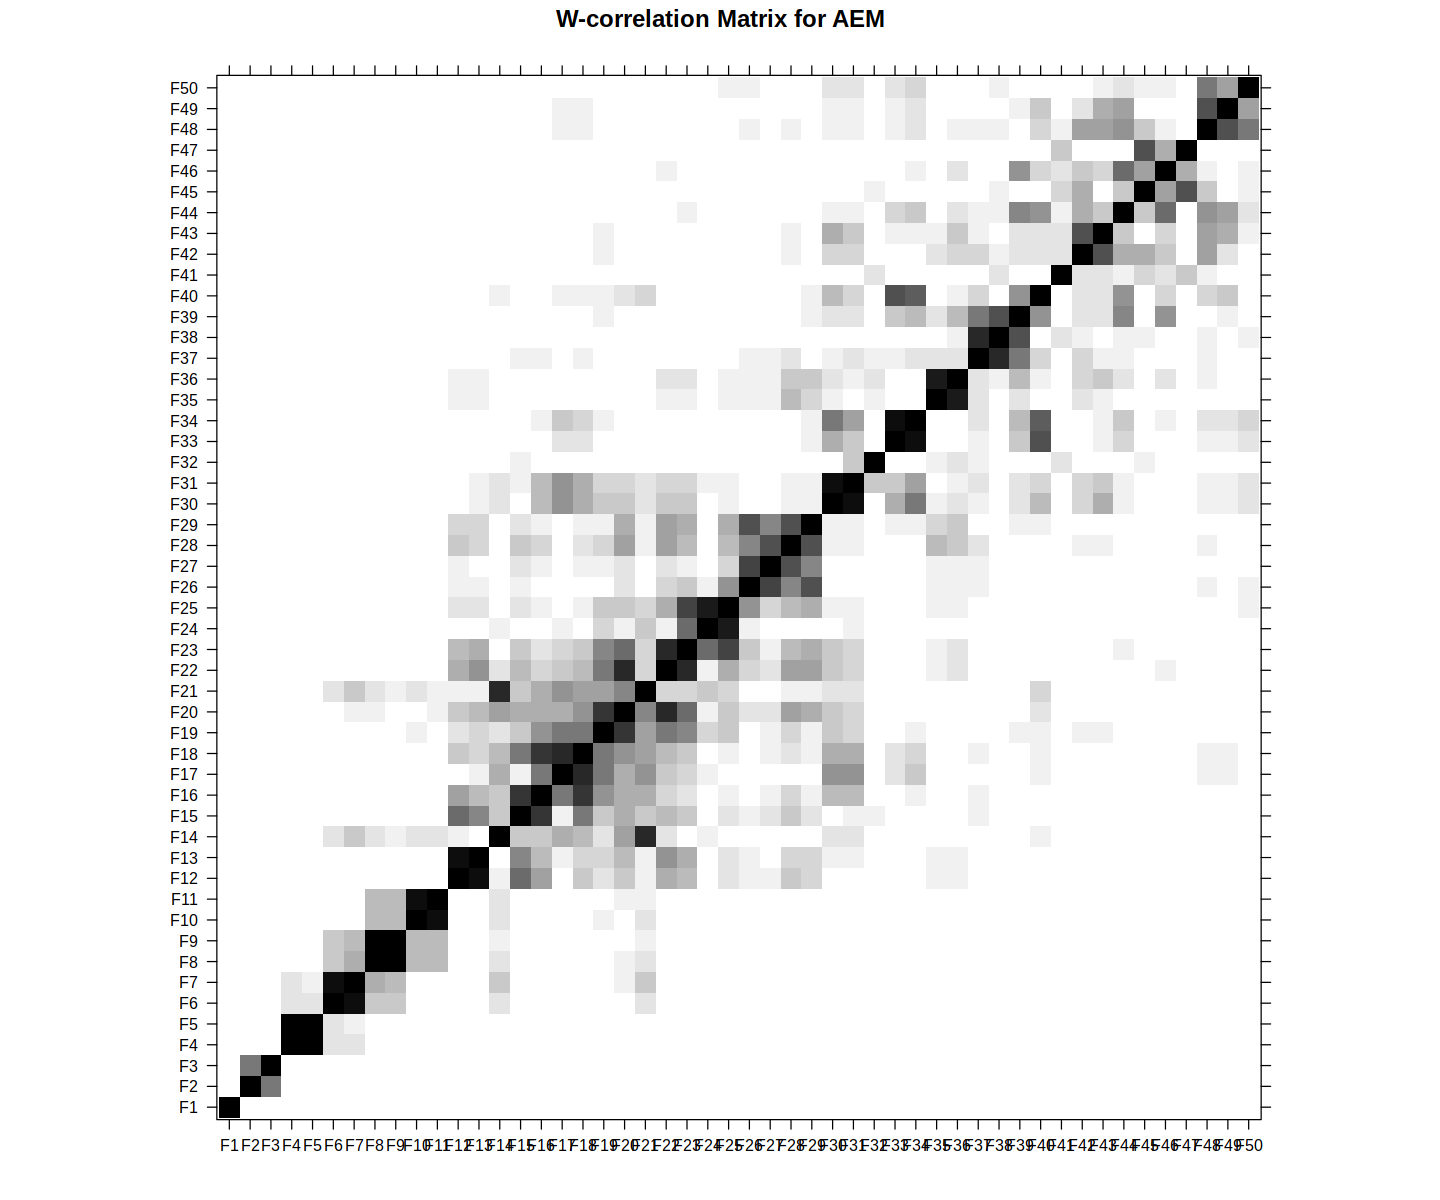

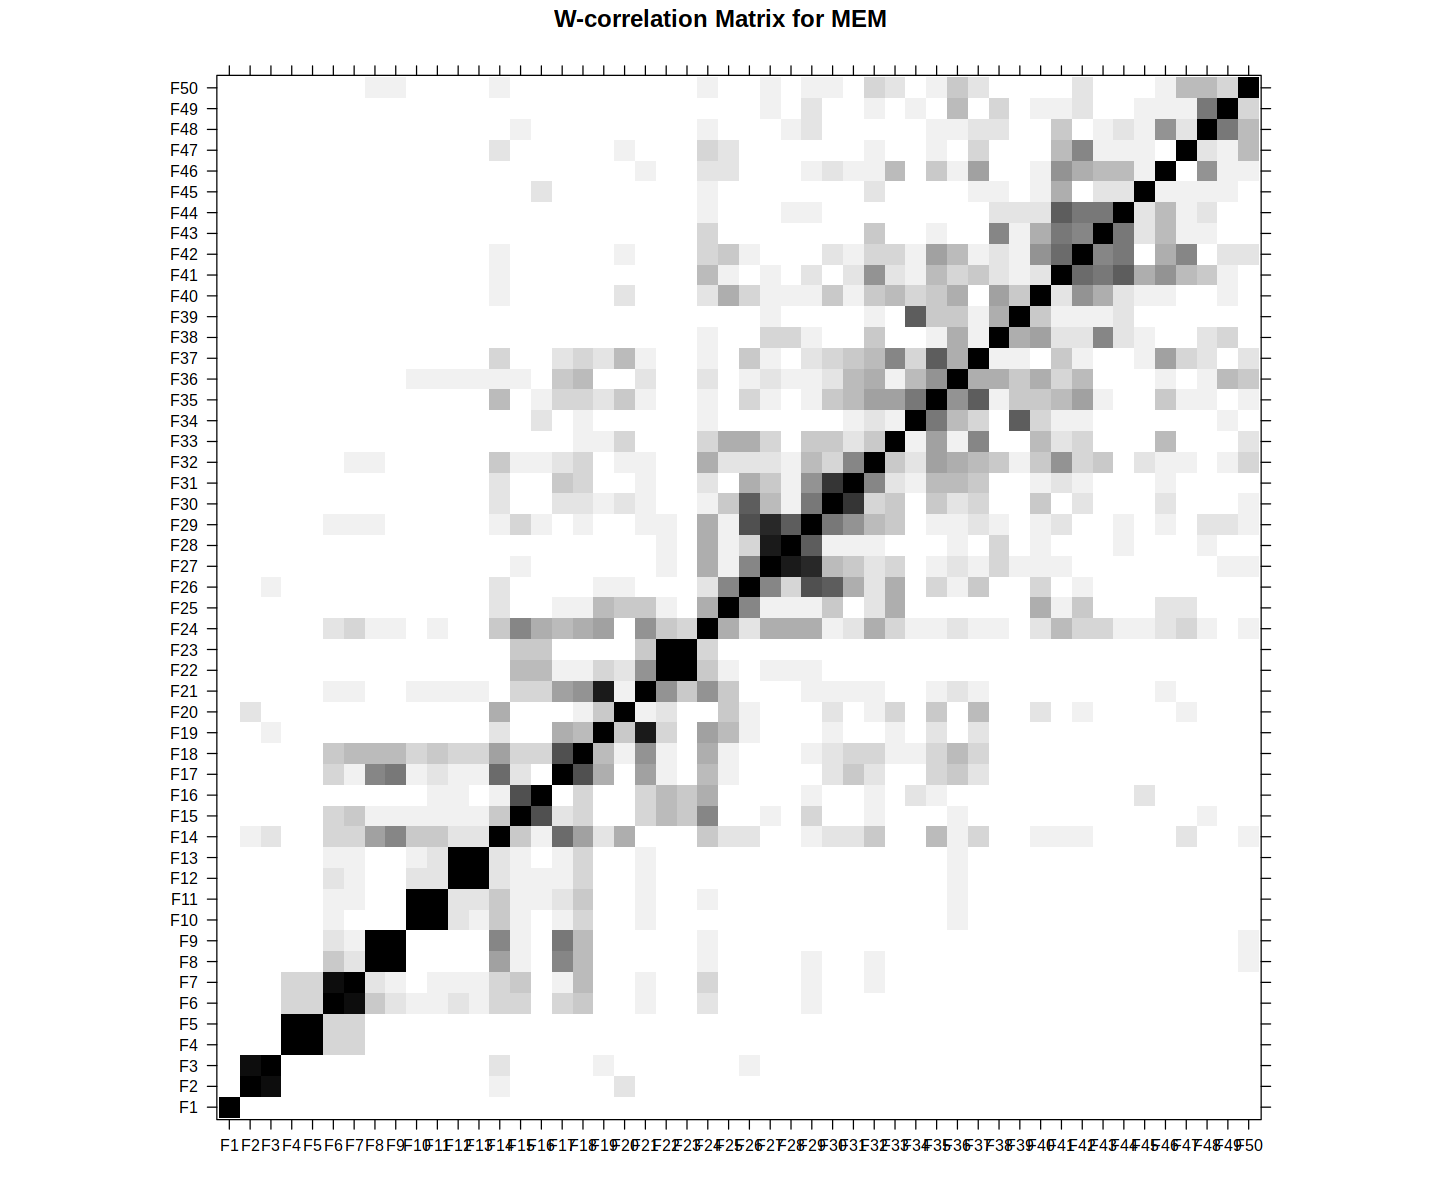

In [26]:
# Apply SSA to the AEM time series
ssa_AEM <- ssa(AEM_ts)
# Apply SSA to the MEM time series
ssa_MEM <- ssa(MEM_ts)

options(repr.plot.width = 12, repr.plot.height = 10)
# W-correlation Matrix for AEM
plot(wcor(ssa_AEM), main = "W-correlation Matrix for AEM")
# W-correlation Matrix for MEM
plot(wcor(ssa_MEM), main = "W-correlation Matrix for MEM")

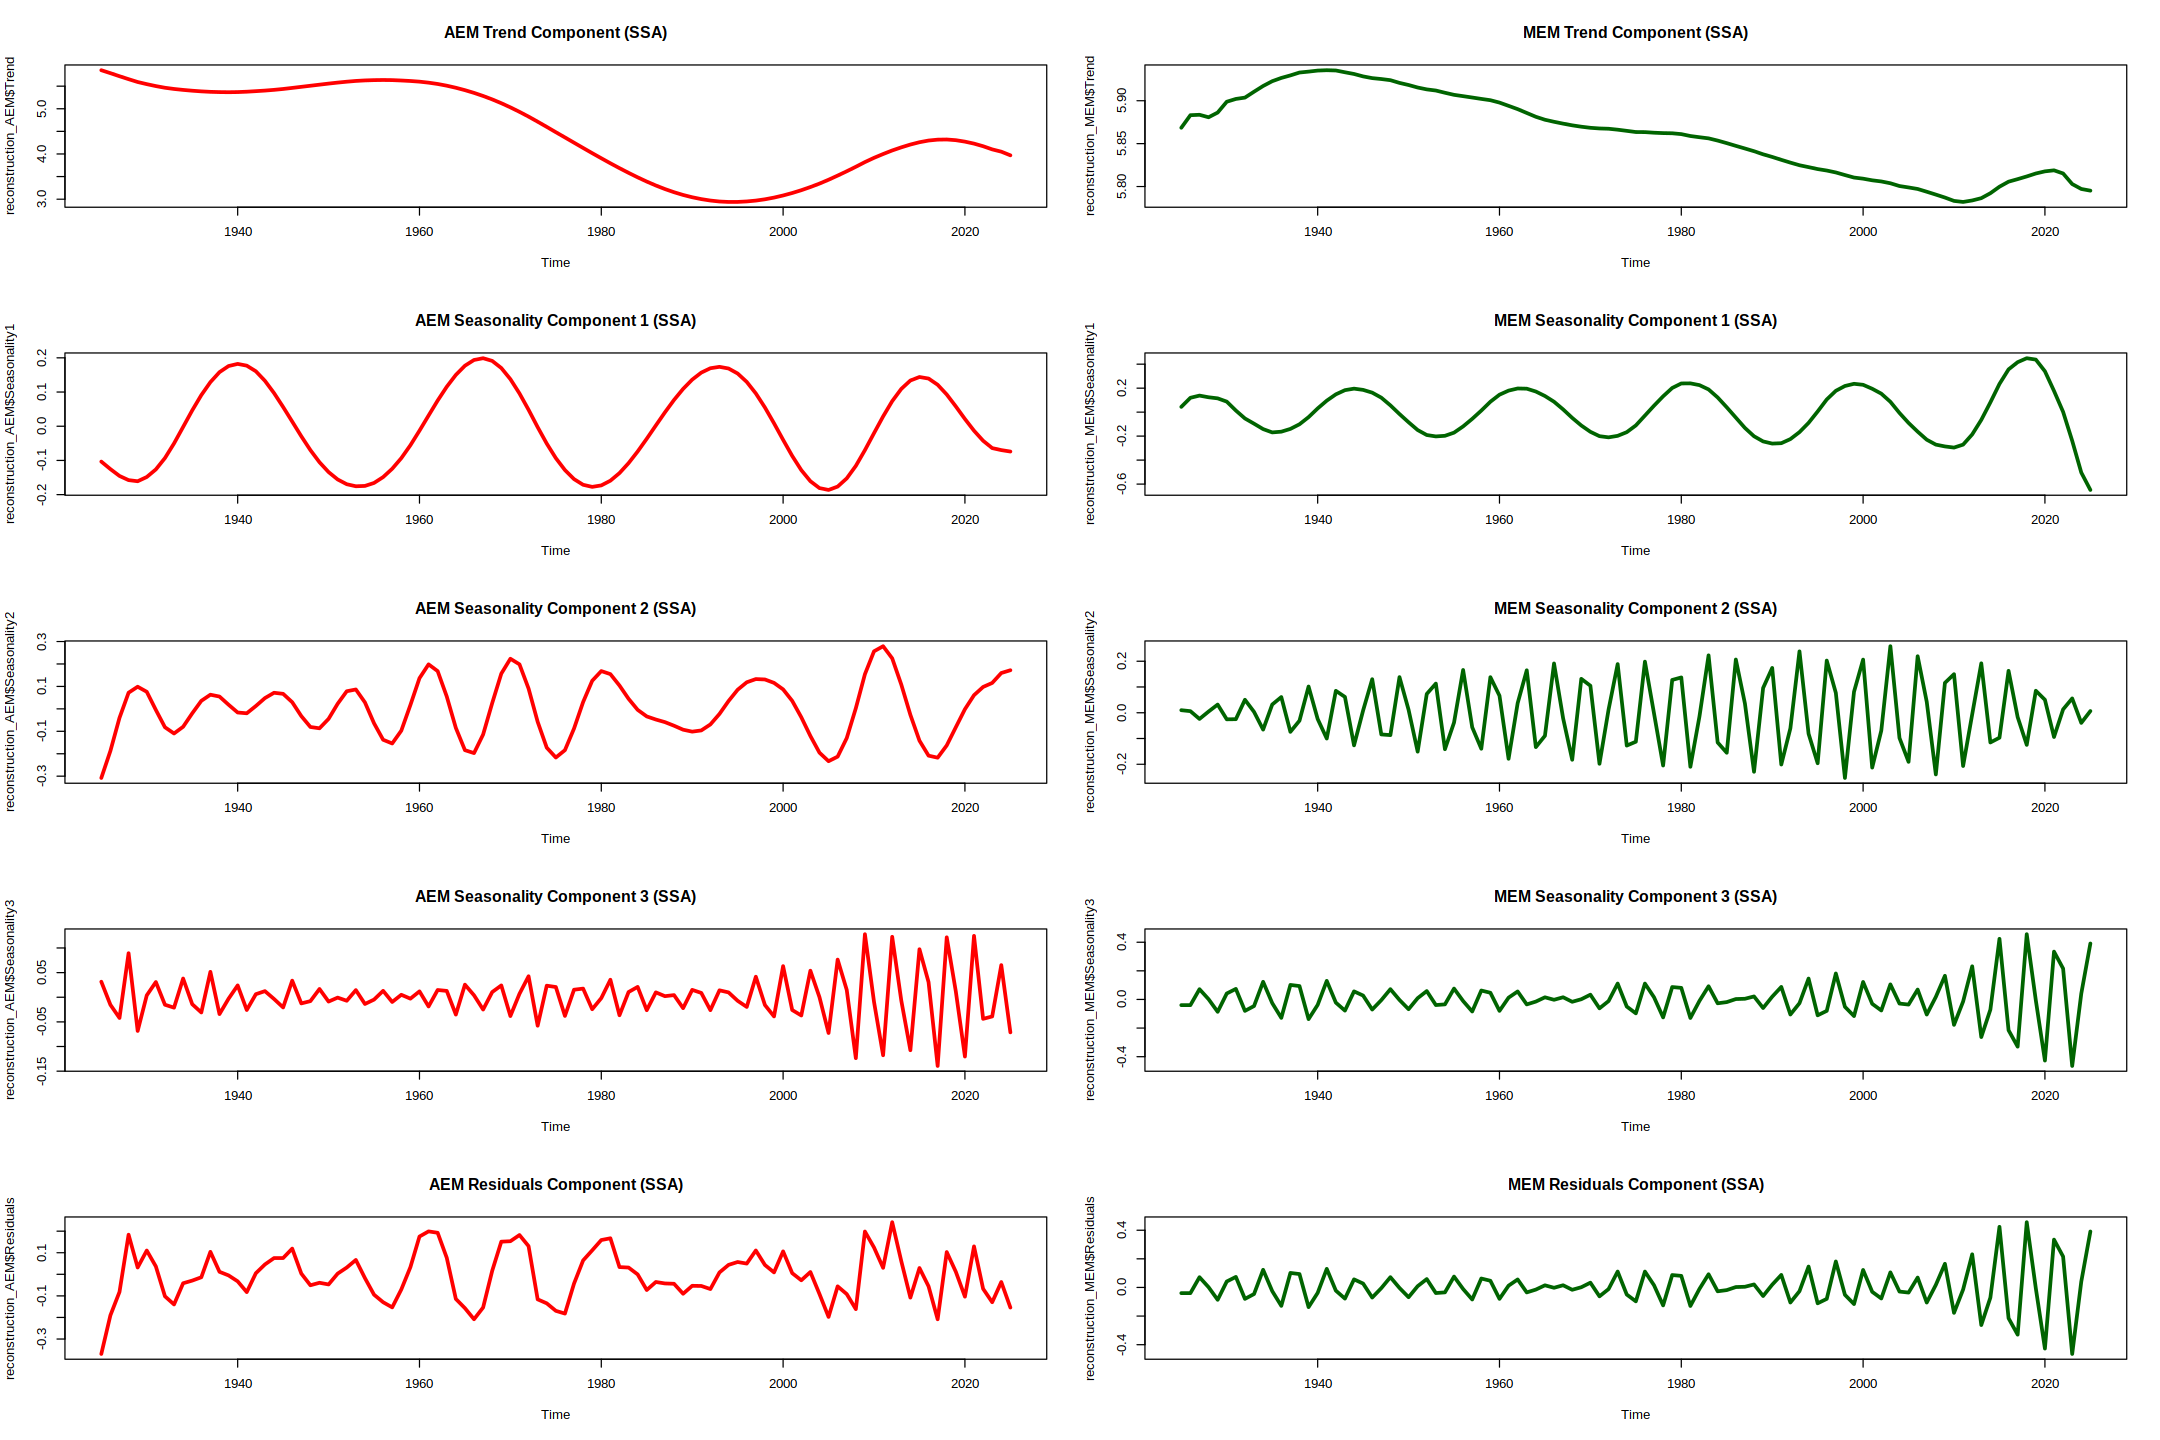

In [27]:
# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_AEM <- reconstruct(ssa_AEM, 
            groups = list(Trend = 1:3, Seasonality1 = 4:5, Seasonality2 = 6:11, Seasonality3 = 12:13, Residuals = 14:length(ssa_AEM)))
# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_MEM <- reconstruct(ssa_MEM, 
            groups = list(Trend = 1, Seasonality1 = 2:3, Seasonality2 = 4:5, Seasonality3 = 6:7, Residuals = 6:length(ssa_MEM)))

# Side by side plots
options(repr.plot.width = 18, repr.plot.height = 12)
par(mfrow = c(5, 2))
plot(reconstruction_AEM$Trend, type = "l", col = "red", main = "AEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_MEM$Trend, type = "l", col = "darkgreen", main = "MEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_AEM$Seasonality1, type = "l", col = "red", main = "AEM Seasonality Component 1 (SSA)", lwd = 3)
plot(reconstruction_MEM$Seasonality1, type = "l", col = "darkgreen", main = "MEM Seasonality Component 1 (SSA)", lwd = 3)
plot(reconstruction_AEM$Seasonality2, type = "l", col = "red", main = "AEM Seasonality Component 2 (SSA)", lwd = 3)
plot(reconstruction_MEM$Seasonality2, type = "l", col = "darkgreen", main = "MEM Seasonality Component 2 (SSA)", lwd = 3)
plot(reconstruction_AEM$Seasonality3, type = "l", col = "red", main = "AEM Seasonality Component 3 (SSA)", lwd = 3)
plot(reconstruction_MEM$Seasonality3, type = "l", col = "darkgreen", main = "MEM Seasonality Component 3 (SSA)", lwd = 3)
plot(reconstruction_AEM$Residuals, type = "l", col = "red", main = "AEM Residuals Component (SSA)", lwd = 3)
plot(reconstruction_MEM$Residuals, type = "l", col = "darkgreen", main = "MEM Residuals Component (SSA)", lwd = 3)
par(mfrow = c(1,1))

#### FORECASTING
We want now to forecasts the next 10 values of the time series using the chosen components from before.

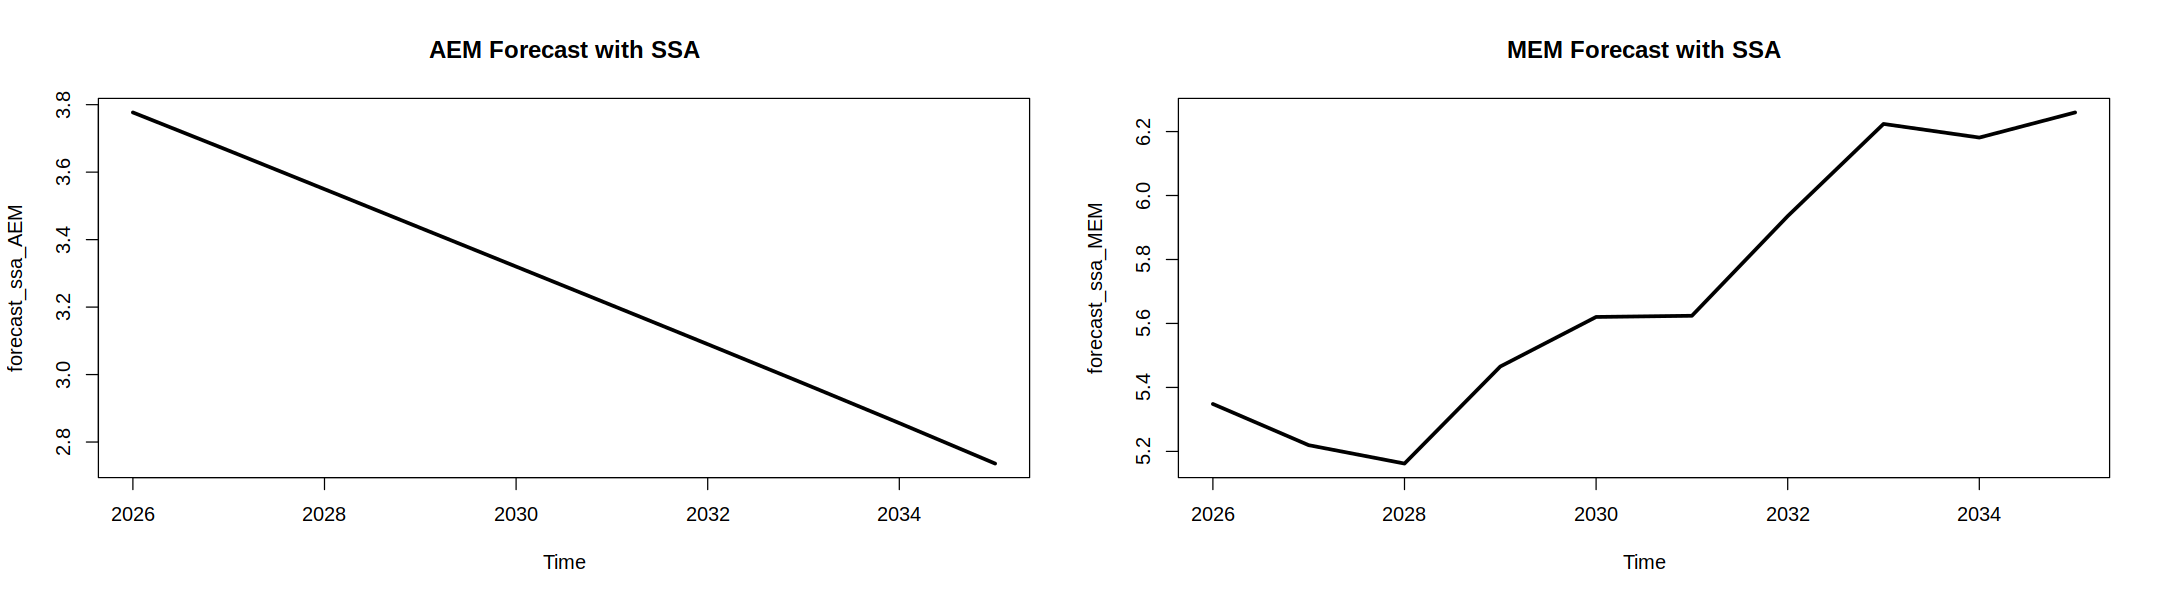

In [28]:
# Forecast next 10 years using SSA
forecast_ssa_AEM <- rforecast(ssa_AEM, groups = list(1:5), len = 10)
# Forecast for MEM
forecast_ssa_MEM <- rforecast(ssa_MEM, groups = list(1:5), len = 10)

# Plot the forecast
options(repr.plot.width = 18, repr.plot.height = 5)
par(mfrow = c(1, 2))
plot(forecast_ssa_AEM, main = "AEM Forecast with SSA", lwd = 3)
plot(forecast_ssa_MEM, main = "MEM Forecast with SSA" , lwd = 3)
par(mfrow = c(1,1))

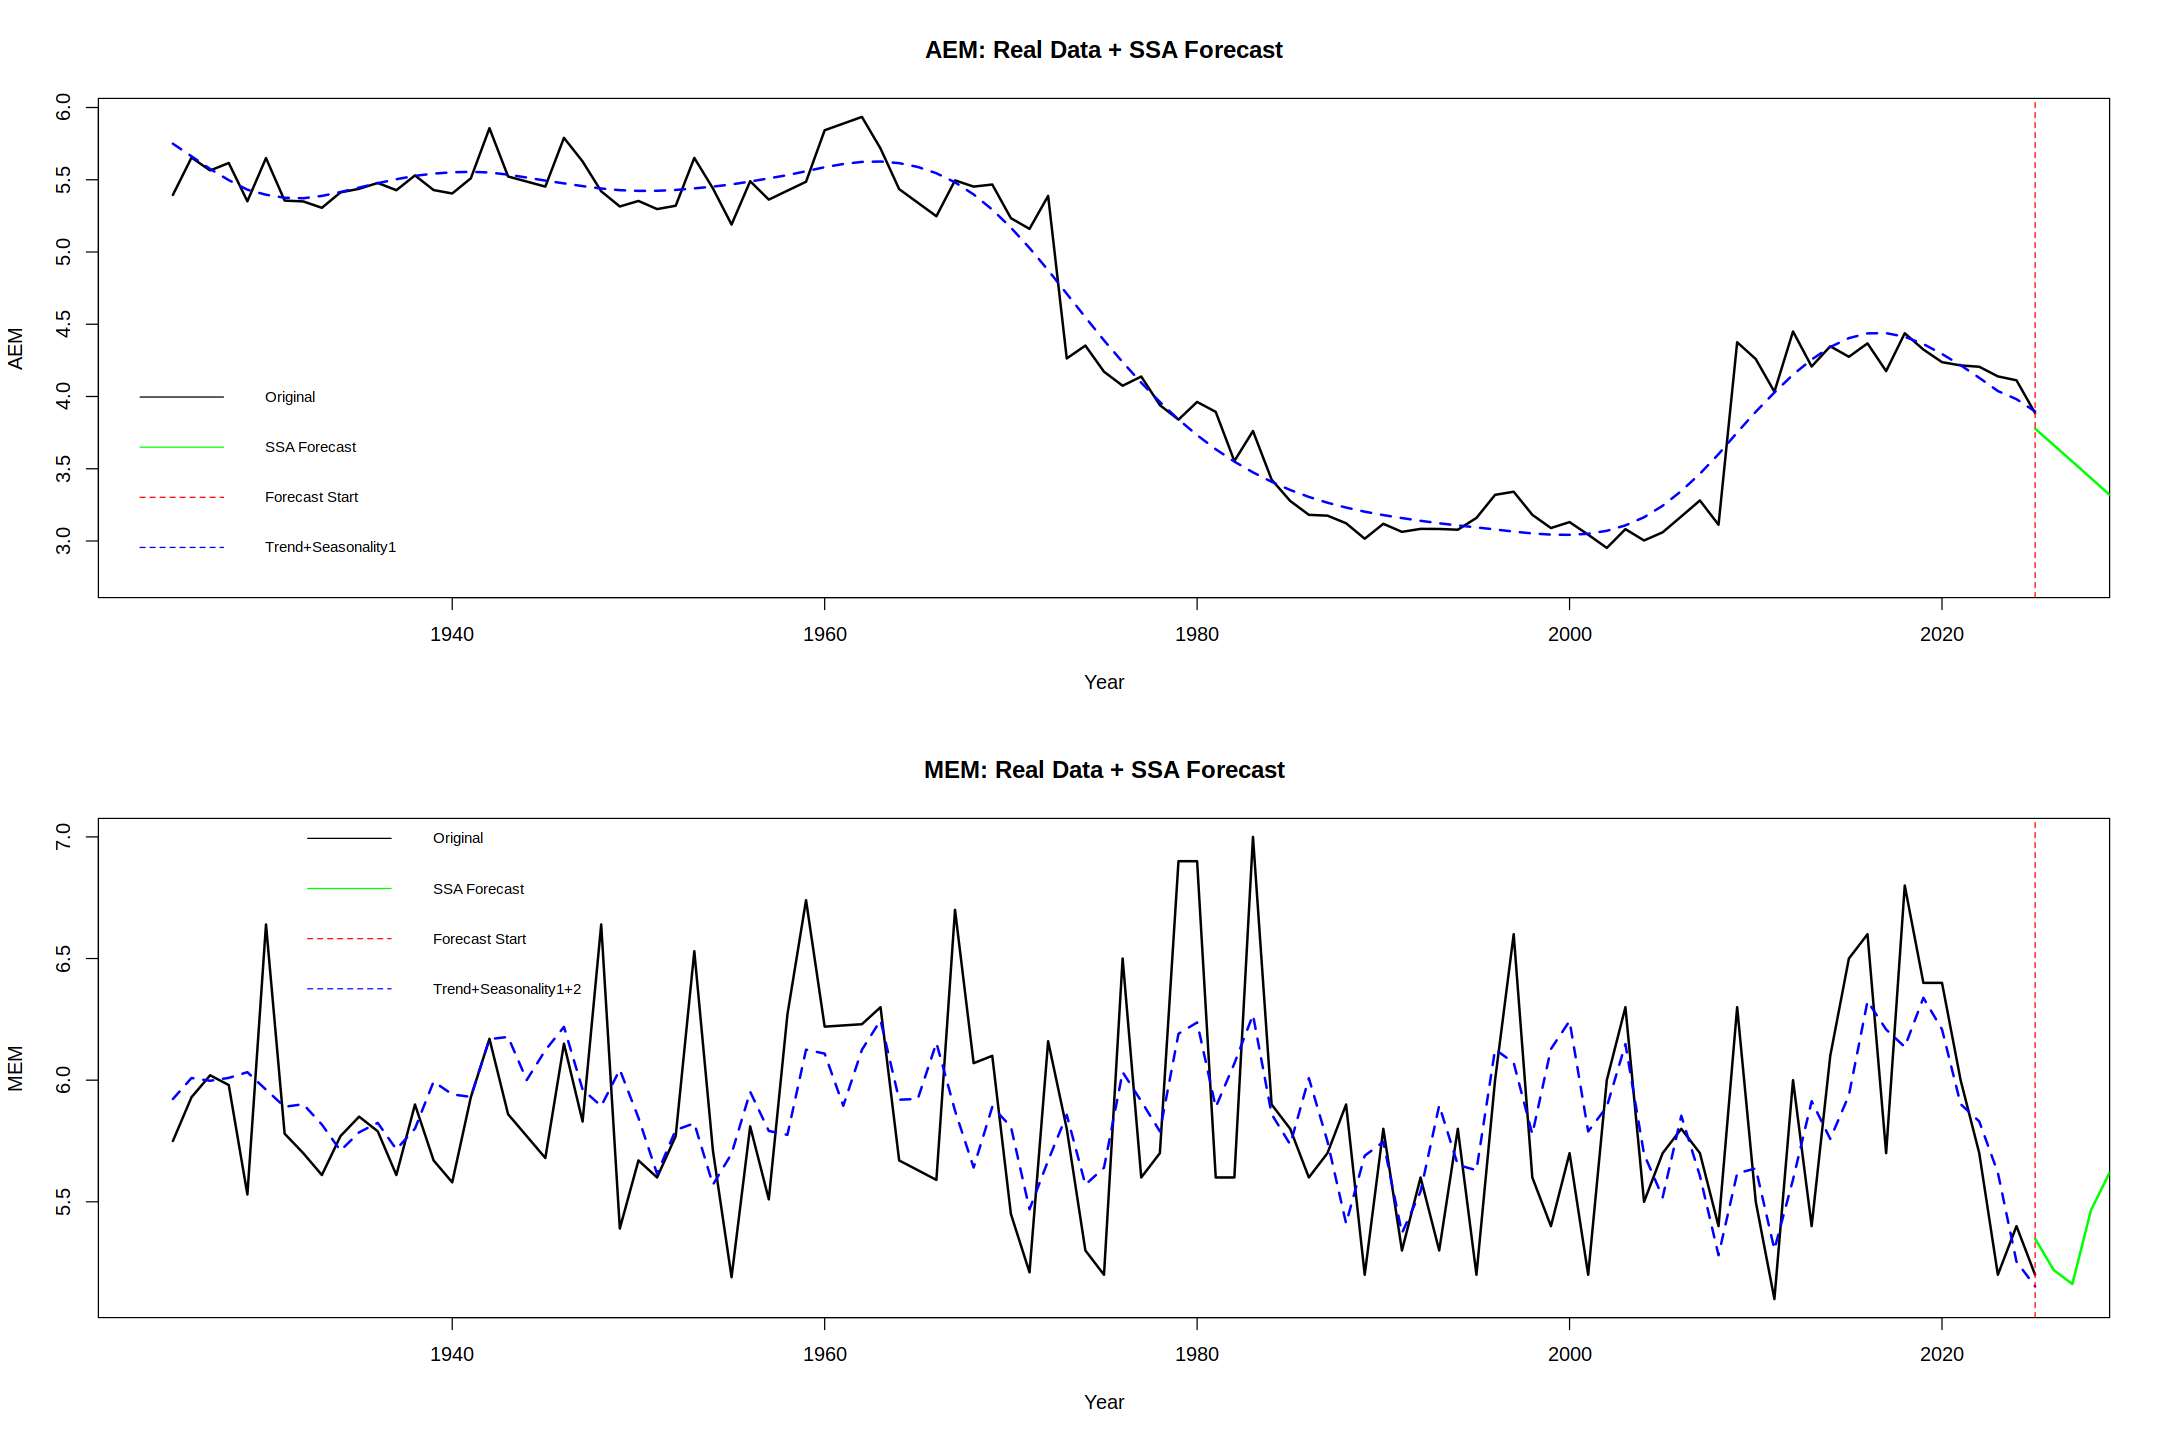

In [29]:
# Forecast series only
forecast_years <- (end(AEM_ts)[1]):(end(AEM_ts)[1] + 10)
# Convert SSA forecast (vector) into time series object
forecast_ts_AEM <- ts(forecast_ssa_AEM, start = end(AEM_ts)[1], frequency = 1)
forecast_ts_MEM <- ts(forecast_ssa_MEM, start = end(MEM_ts)[1], frequency = 1)


# PLOT:
options(repr.plot.width = 18, repr.plot.height = 12)
par(mfrow = c(2, 1))

# PLOT1:
plot(AEM_ts, type = "l", lwd = 2, col = "black", ylim = range(c(AEM_ts, forecast_ts_AEM)),
     main = "AEM: Real Data + SSA Forecast", xlab = "Year", ylab = "AEM")
lines(reconstruction_AEM$Trend + reconstruction_AEM$Seasonality1, col = "blue", lwd = 2, lty = 2)  # SSA Trend
lines(forecast_ts_AEM, col = "green", lwd = 2)
abline(v = end(AEM_ts)[1], col = "red", lty = 2)
legend("bottomleft", legend = c("Original", "SSA Forecast", "Forecast Start", "Trend+Seasonality1"),
       col = c("black", "green", "red","blue"), lty = c(1,1,2,2), bty = "n", cex = 0.75)

# PLOT2:
plot(MEM_ts, type = "l", lwd = 2, col = "black", ylim = range(c(MEM_ts, forecast_ts_MEM)),
     main = "MEM: Real Data + SSA Forecast", xlab = "Year", ylab = "MEM")
lines(reconstruction_MEM$Trend + reconstruction_MEM$Seasonality1 + + reconstruction_MEM$Seasonality2, col = "blue", lwd = 2, lty = 2)  # SSA Trend
lines(forecast_ts_MEM, col = "green", lwd = 2)
abline(v = end(MEM_ts)[1], col = "red", lty = 2)
legend(x = 1930, y = 7.2, legend = c("Original", "SSA Forecast", "Forecast Start", "Trend+Seasonality1+2"),
       col = c("black", "green", "red","blue"), lty = c(1,1,2,2), bty = "n",cex = 0.75)

par(mfrow = c(1, 1))


Like before, for the AEM time series, we reconstructed the data using the trend component and the first seasonal component, as these showed the least noise in the component plots.  
For the MEM series, we used the trend and the first two seasonal components.  

---

# COMPARISON OF THE TWO METHODS THROUGH RMSE

RMSE (root mean square error ) for the two methods.
For n data points:

$$RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }$$

Where:
	•	$y_i$ = actual observed value. 
	•	$\hat{y}_i$ = predicted value

Lower RMSE = Better model fit, assuming residuals behave like white noise.

In [30]:
# AEM RMSE for ARIMA
actual_AEM <- AEM_ts
fitted_AEM <- fitted(model_AEM)
rmse_AEM_arima <- sqrt(mean((actual_AEM - fitted_AEM)^2, na.rm = TRUE))

# MEM RMSE for ARIMA
actual_MEM <- MEM_ts
fitted_MEM <- fitted(model_MEM)
rmse_MEM_arima <- sqrt(mean((actual_MEM - fitted_MEM)^2, na.rm = TRUE))

# SSA RMSE for AEM
recon_AEM <- reconstruction_AEM$Trend + reconstruction_AEM$Seasonality1 + reconstruction_AEM$Seasonality2
rmse_AEM_ssa <- sqrt(mean((AEM_ts - recon_AEM)^2, na.rm = TRUE))

# SSA RMSE for MEM
recon_MEM <- reconstruction_MEM$Trend + reconstruction_MEM$Seasonality1 + reconstruction_MEM$Seasonality2
rmse_MEM_ssa <- sqrt(mean((MEM_ts - recon_MEM)^2, na.rm = TRUE))

In [31]:
# RMSE summary table
rmse_table <- data.frame(
  Method = c("ARIMA", "SSA"),
  AEM_RMSE = c(rmse_AEM_arima, rmse_AEM_ssa),
  MEM_RMSE = c(rmse_MEM_arima, rmse_MEM_ssa)
)
rmse_table

Method,AEM_RMSE,MEM_RMSE
<chr>,<dbl>,<dbl>
ARIMA,0.2269236,0.4359673
SSA,0.1368822,0.3671345


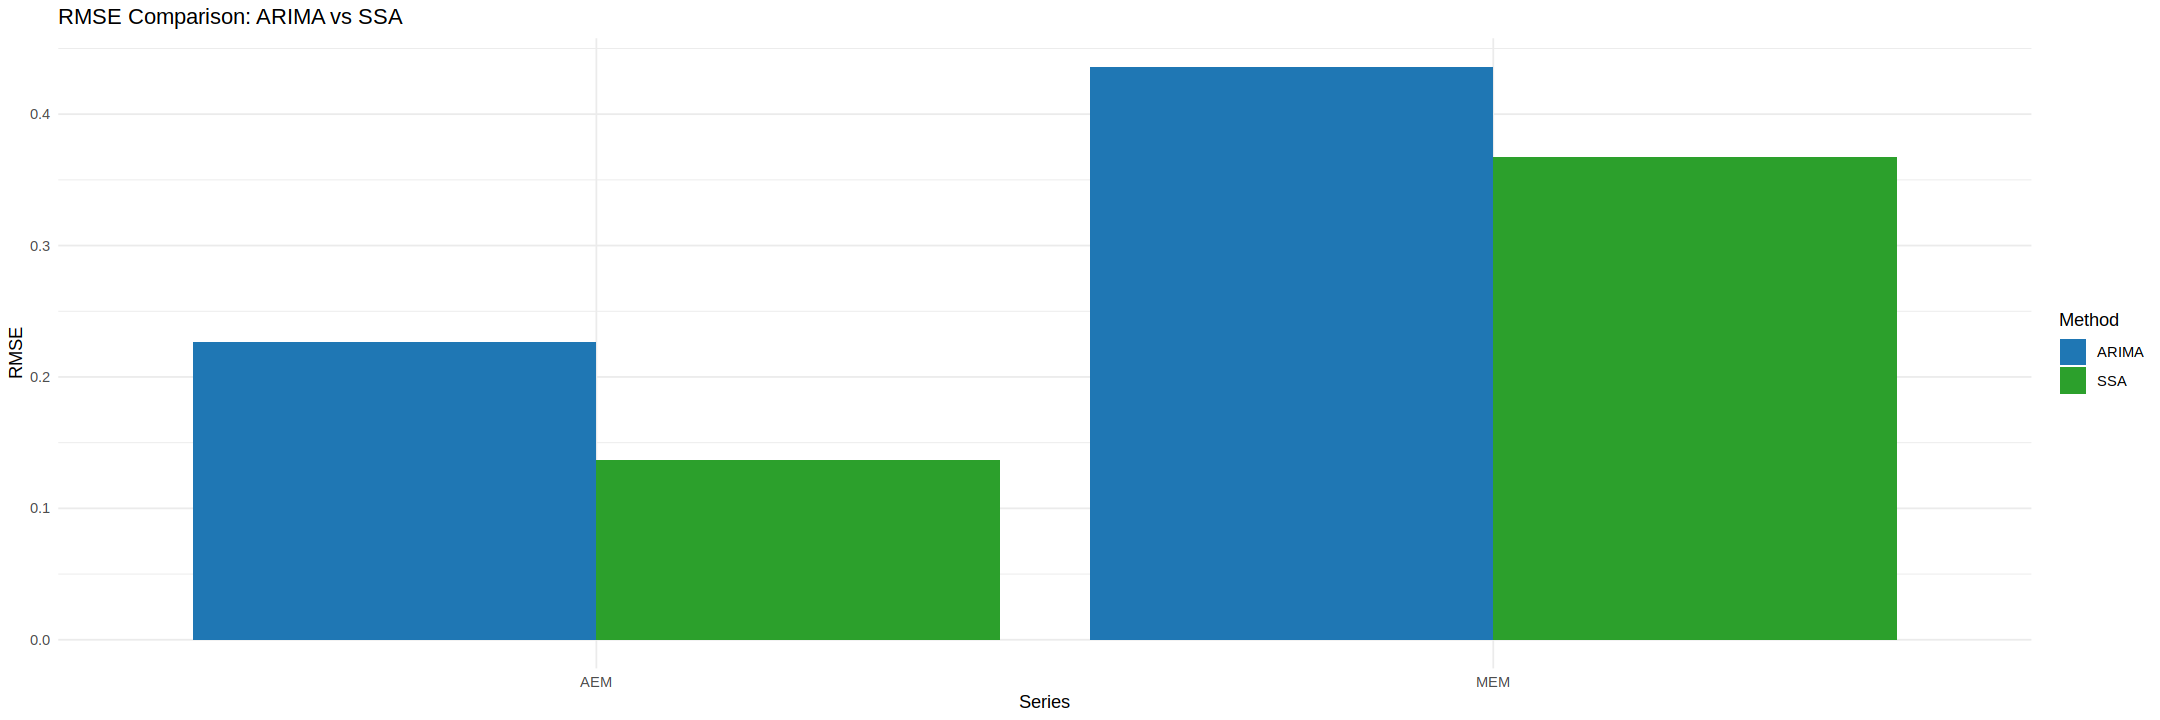

In [32]:
# Create data frame for RMSE values
rmse_df <- data.frame(
  Method = rep(c("ARIMA", "SSA"), each = 2),
  Series = rep(c("AEM", "MEM"), times = 2),
  RMSE = c(rmse_AEM_arima, rmse_MEM_arima, rmse_AEM_ssa, rmse_MEM_ssa)
)

# Plot grouped bar chart
options(repr.plot.width = 18, repr.plot.height = 6)
ggplot(rmse_df, aes(x = Series, y = RMSE, fill = Method)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "RMSE Comparison: ARIMA vs SSA",
       y = "RMSE",
       x = "Series") +
  theme_minimal() +
  scale_fill_manual(values = c("ARIMA" = "#1f77b4", "SSA" = "#2ca02c"))


Based on RMSE, SSA provides a better in-sample fit than ARIMA for both AEM and MEM time series. This suggests that SSA is more effective at capturing the underlying structure — particularly trend and seasonal components — in the historical data.

---